In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re
from attrdict import AttrDict

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
varinfo.clear()

dout = 'gnn_abcd/'

In [3]:
varinfo.Y1_m = dict(bins=np.linspace(0,1000,30))
varinfo.Y2_m = dict(bins=np.linspace(0,1000,30))

varinfo.H1Y1_m = dict(bins=np.linspace(0,300,30))
varinfo.H2Y1_m = dict(bins=np.linspace(0,300,30))
varinfo.H1Y2_m = dict(bins=np.linspace(0,300,30))
varinfo.H2Y2_m = dict(bins=np.linspace(0,300,30))


In [4]:
bkgtrees = ObjIter([Tree(filter(os.path.isfile,fc.eightb.preselection_golden.QCD_B_List))])
# bkgtrees = ObjIter([Tree(filter(os.path.isfile,fc.eightb.preselection.QCD_B_List))])
# bkgtrees = ObjIter([])

In [5]:
signaltrees = ObjIter([ Tree(f) for i,f in enumerate(fc.eightb.preselection_golden.signal_list) if i in (0,5,7) ])

In [6]:
for signal in signaltrees: signal.color = None

In [7]:
(bkgtrees + signaltrees).apply(lambda t : build_collection(t, 'Y\d', 'y'))
(bkgtrees + signaltrees).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs'))
(bkgtrees + signaltrees).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'bjet'))

[None, None, None, None]

In [8]:
def btag_multi(tree):
    btag = tree.bjet_btag
    n_mbtag = ak.sum( btag > jet_btagWP[2],axis=-1) 
    n_lbtag = ak.sum( (btag > jet_btagWP[1]) & (btag < jet_btagWP[2]), axis=-1)
    n_nbtag = ak.sum( btag < jet_btagWP[1], axis=-1)

    btagsum = ak.sum( btag,axis=-1)
    tree.extend(n_medium_btag=n_mbtag, n_loose_btag=n_lbtag, n_null_btag=n_nbtag, btagsum=btagsum)
(bkgtrees+signaltrees).apply(btag_multi)

[None, None, None, None]

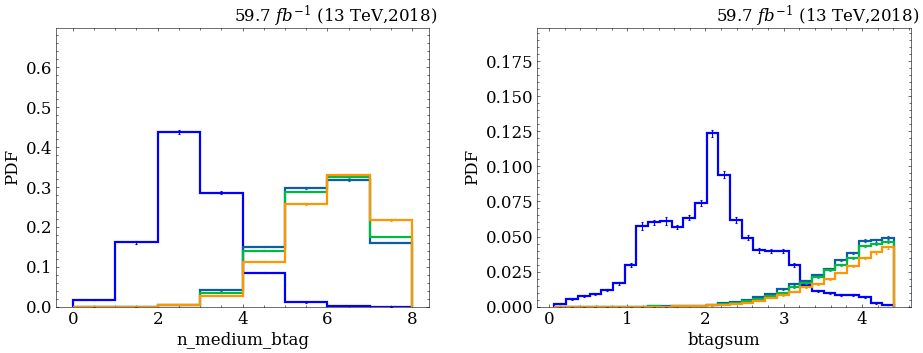

In [80]:
study.quick(
    (bkgtrees+signaltrees),
    varlist=['n_medium_btag','btagsum'],
    density=True,
)

In [14]:
geq4_mbtag = lambda t : t.n_medium_btag >= 4
eq3_mbtag = lambda t : t.n_medium_btag == 3
leq2_mbtag = lambda t : t.n_medium_btag <= 2

In [18]:
objlist = ['X','Y1','H1Y1','H2Y1',None,'Y2','H1Y2','H2Y2']

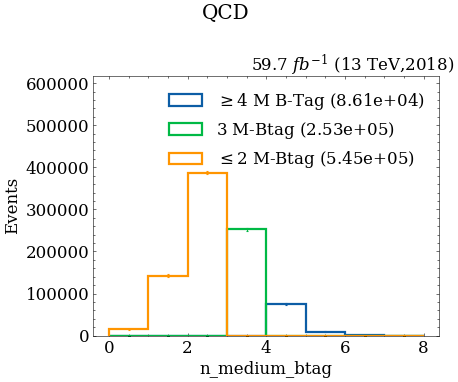

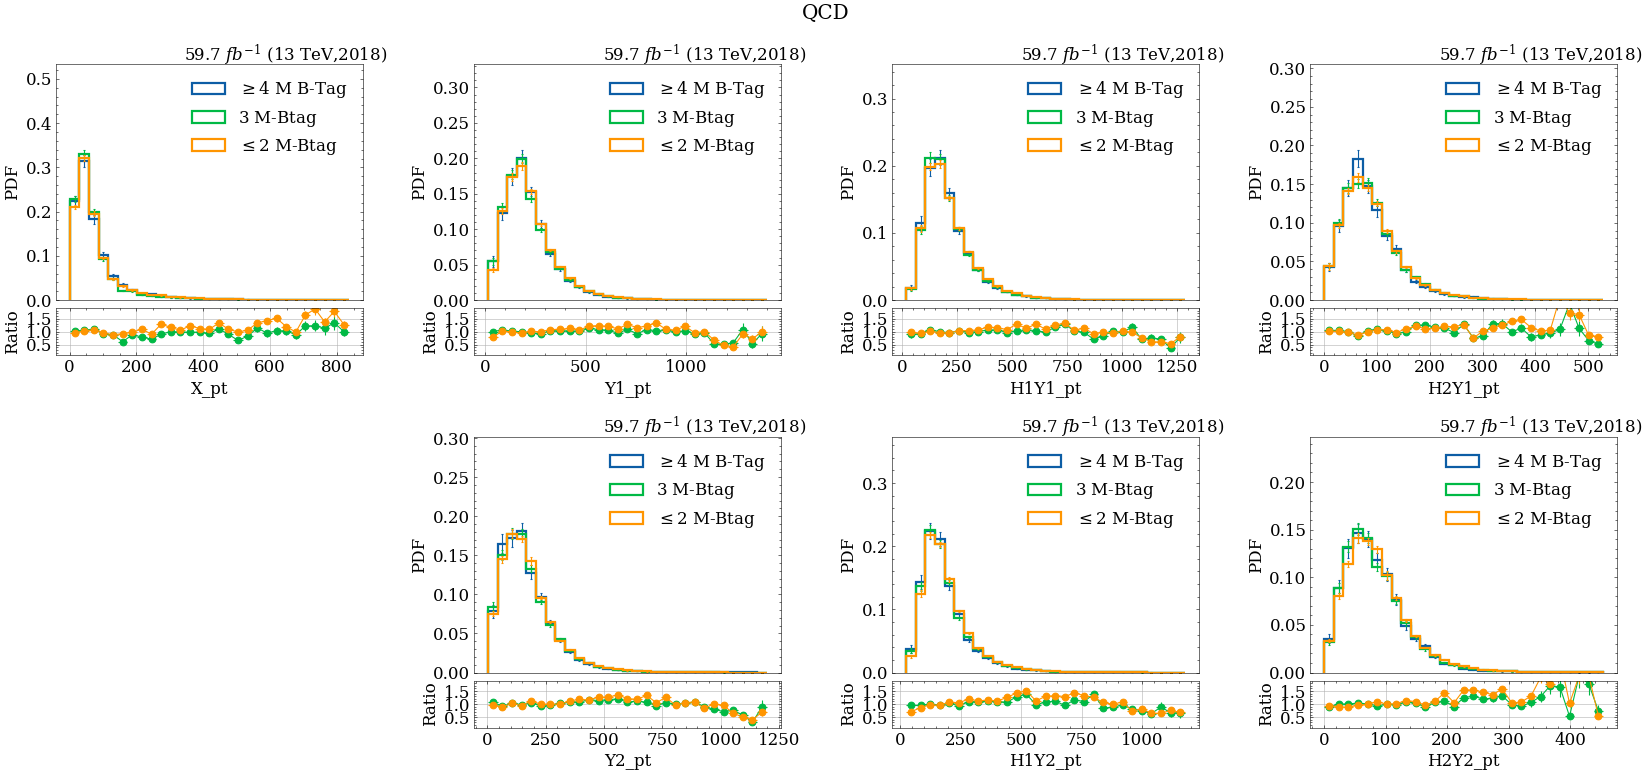

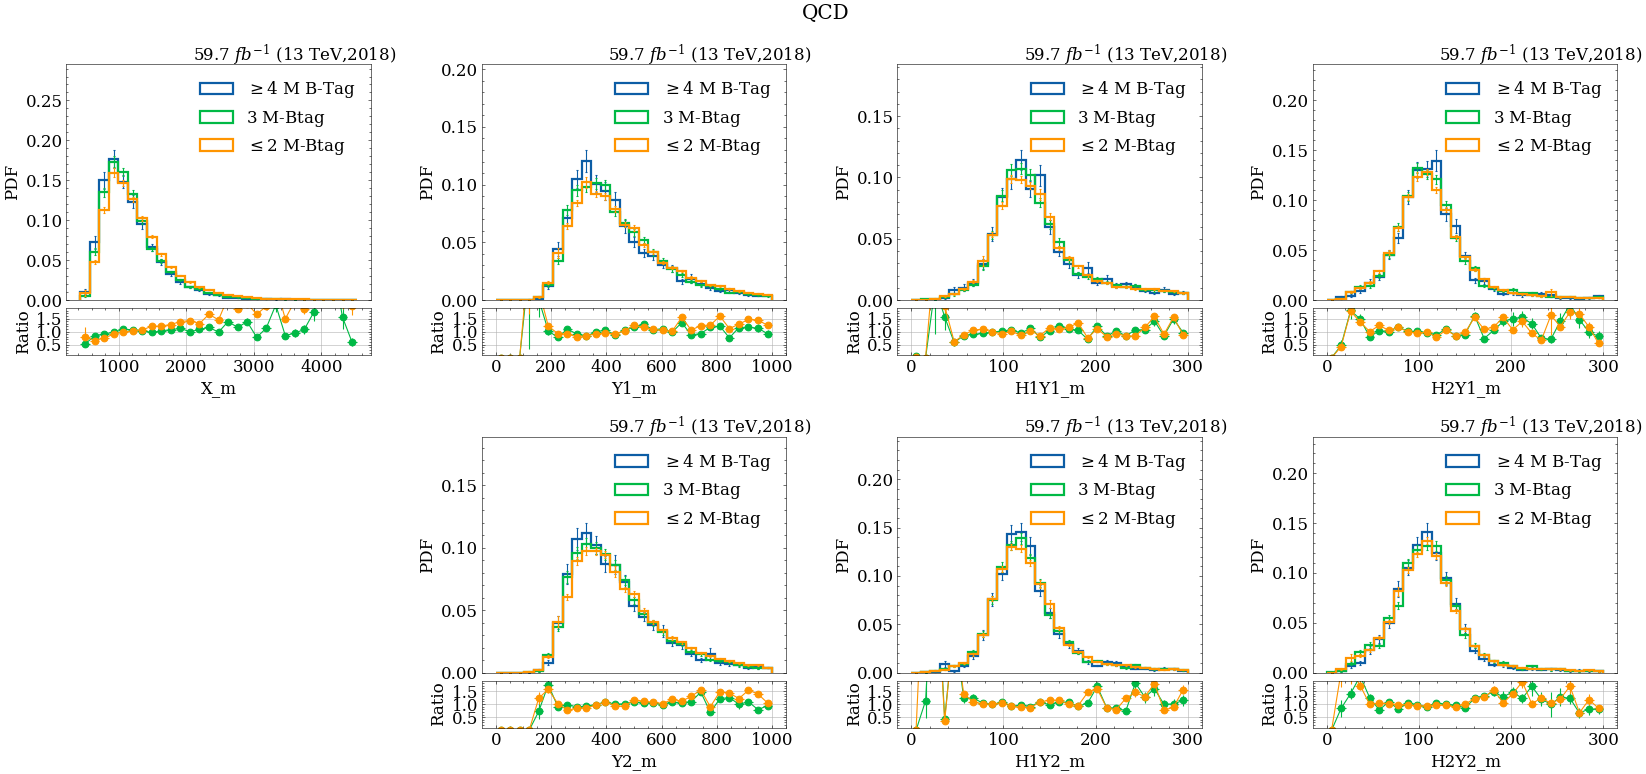

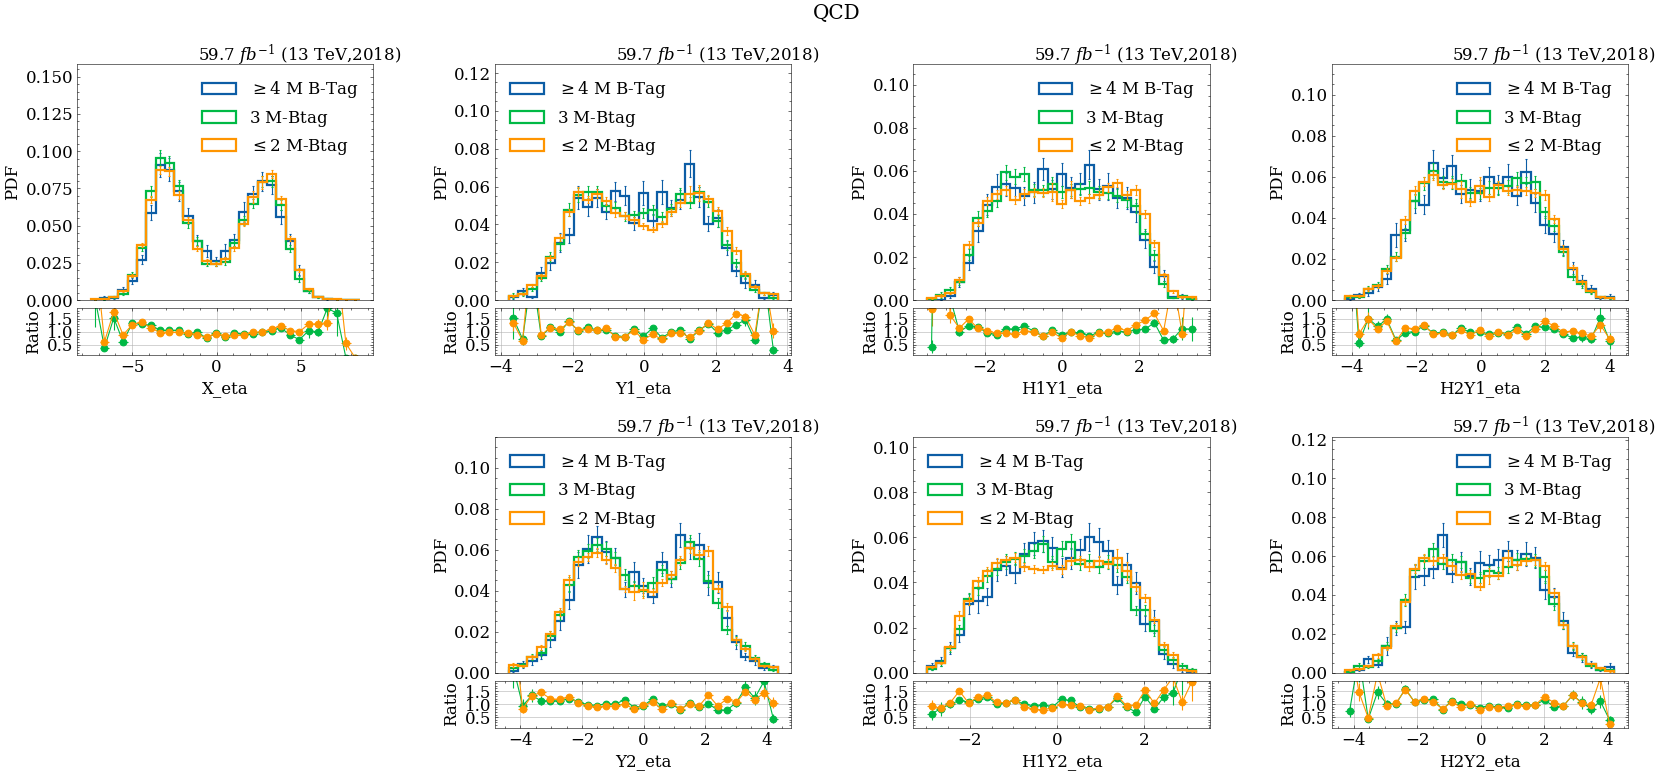

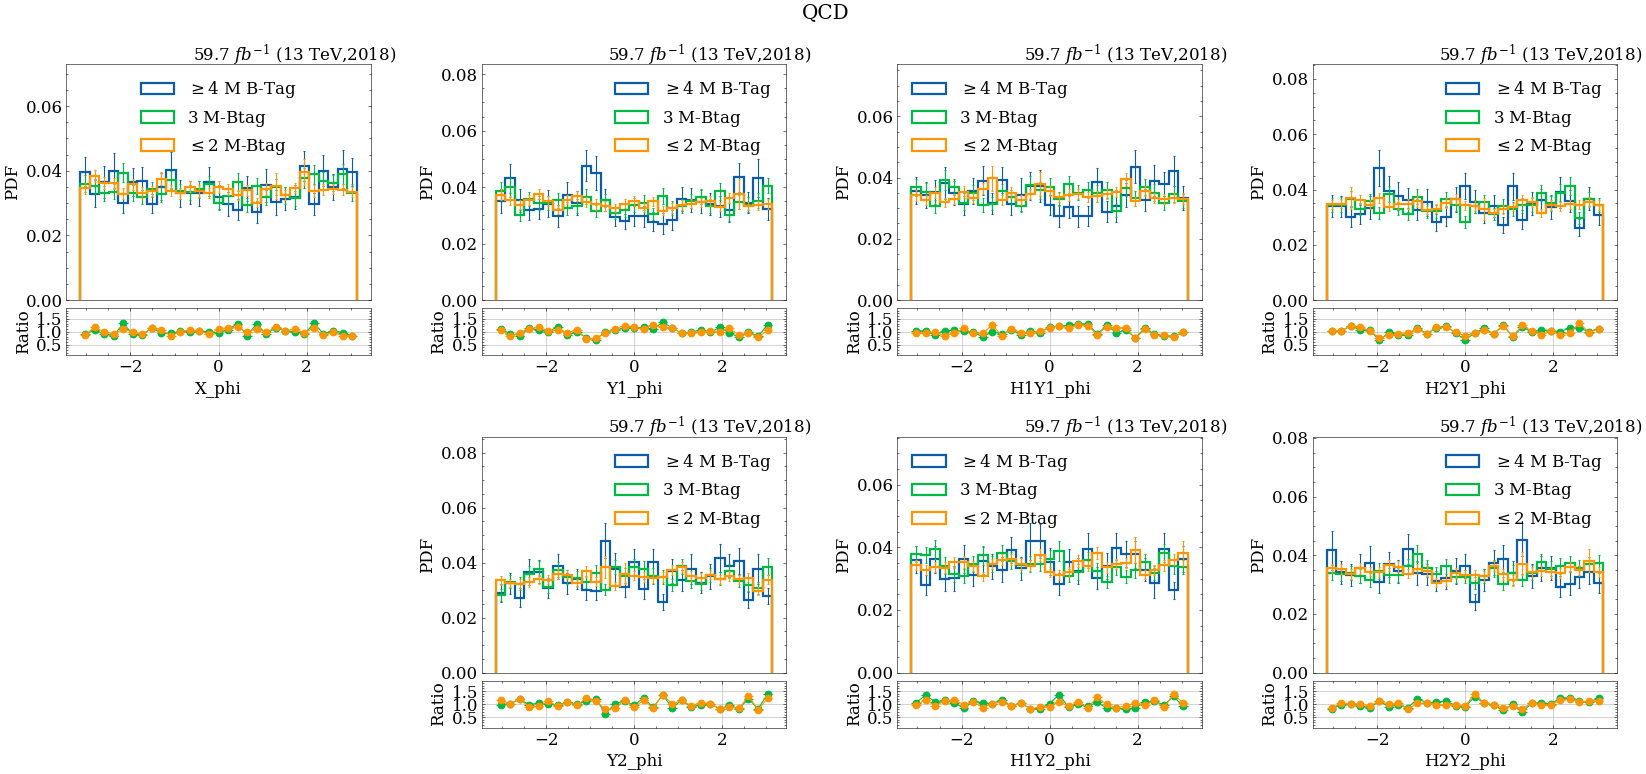

In [43]:
study.quick(
    bkgtrees[[0,0,0]],legend=True,title='QCD',
    masks = [geq4_mbtag, eq3_mbtag, leq2_mbtag],
    h_color=None, label=['$\geq 4$ M B-Tag','$3$ M-Btag', '$\leq 2$ M-Btag'],
    varlist=['n_medium_btag']
)

for var in ('pt','m','eta','phi'):
    study.quick(
        bkgtrees[[0,0,0]],title='QCD',legend=True, h_label_stat=None,
        masks = [geq4_mbtag, eq3_mbtag, leq2_mbtag],
        h_color=None, label=['$\geq 4$ M B-Tag','$3$ M-Btag', '$\leq 2$ M-Btag'],
        varlist=[(f'{obj}_{var}' if obj else None) for obj in objlist], dim=(-1,4),
        # varlist=['X_m'],
        density=True,
        ratio=True,r_inv=True,
    )

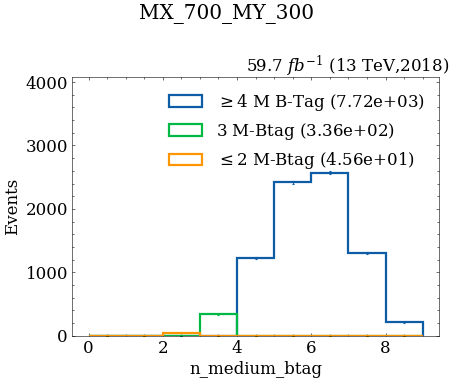

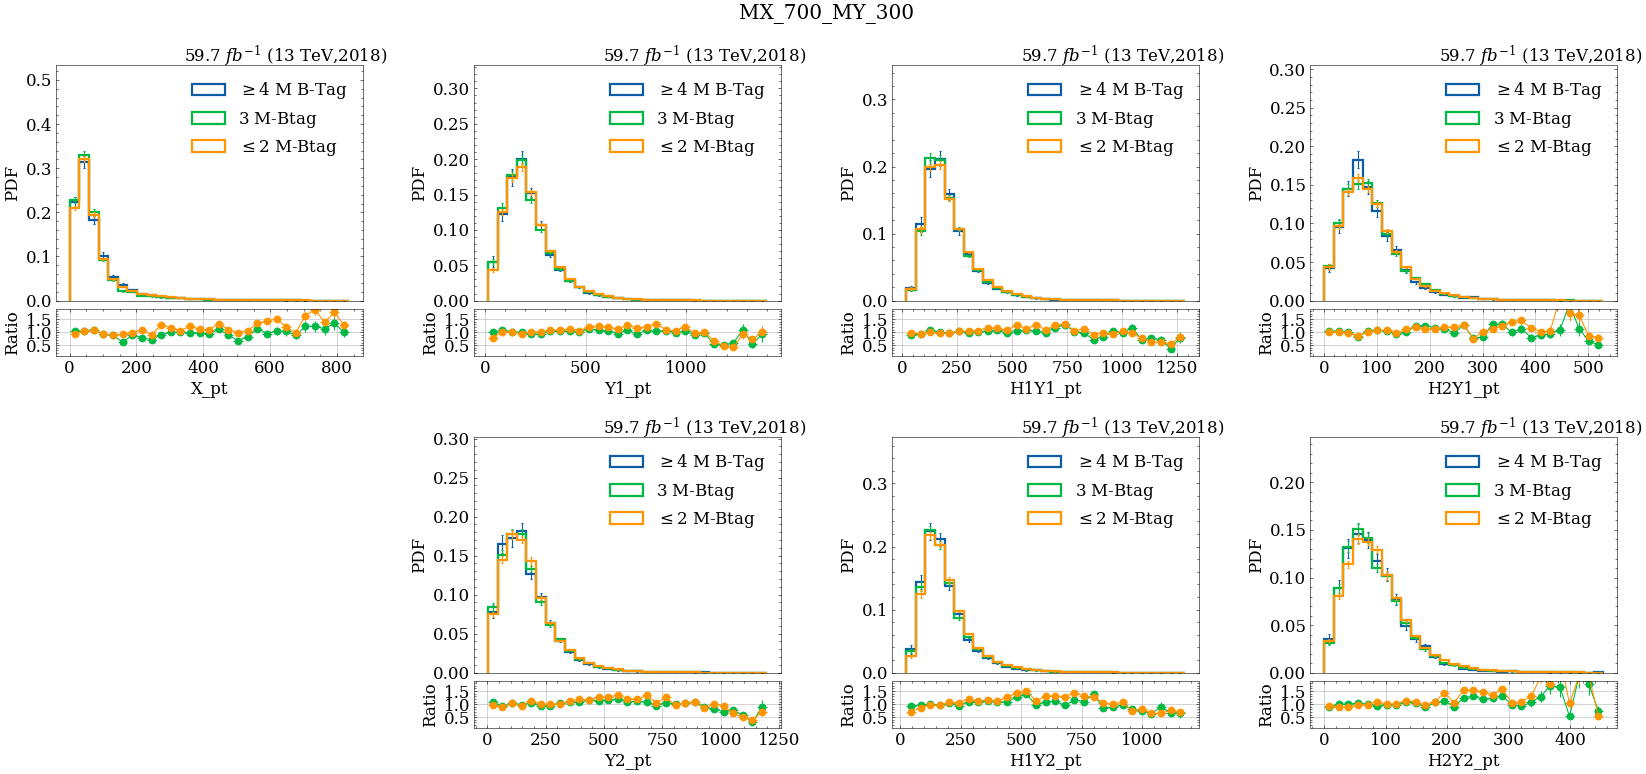

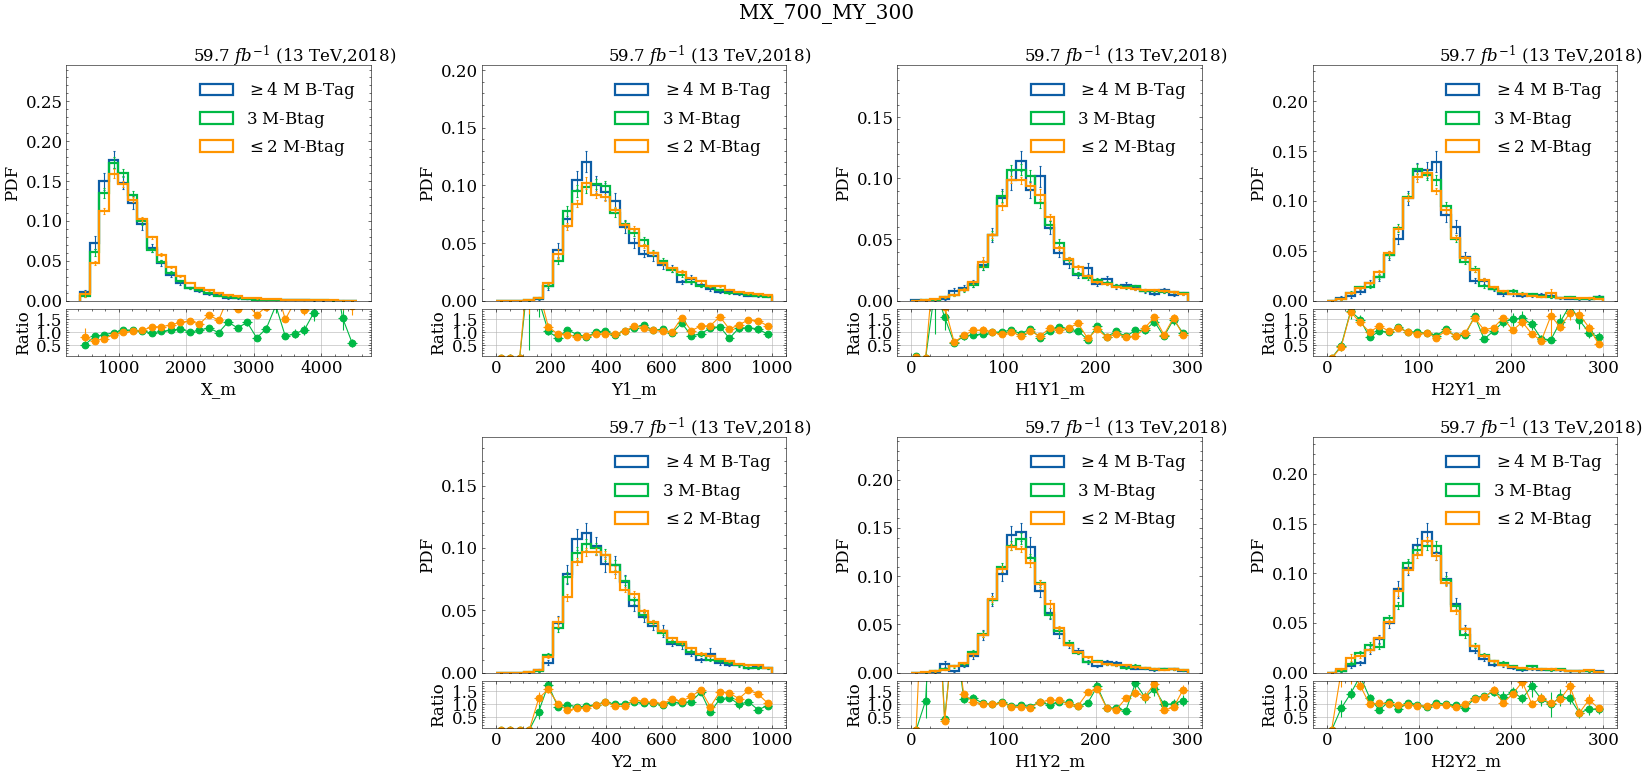

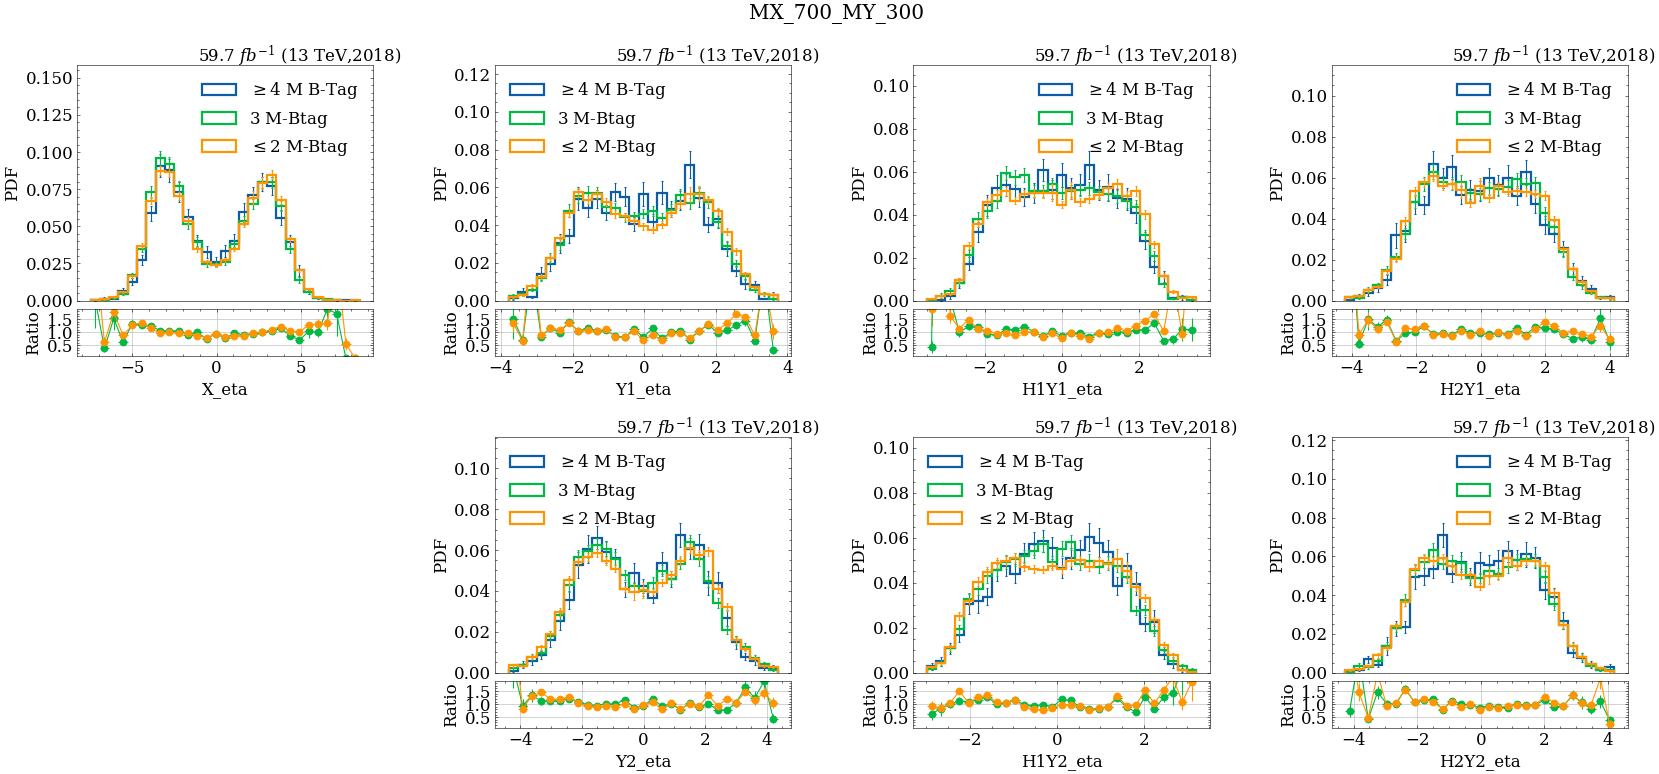

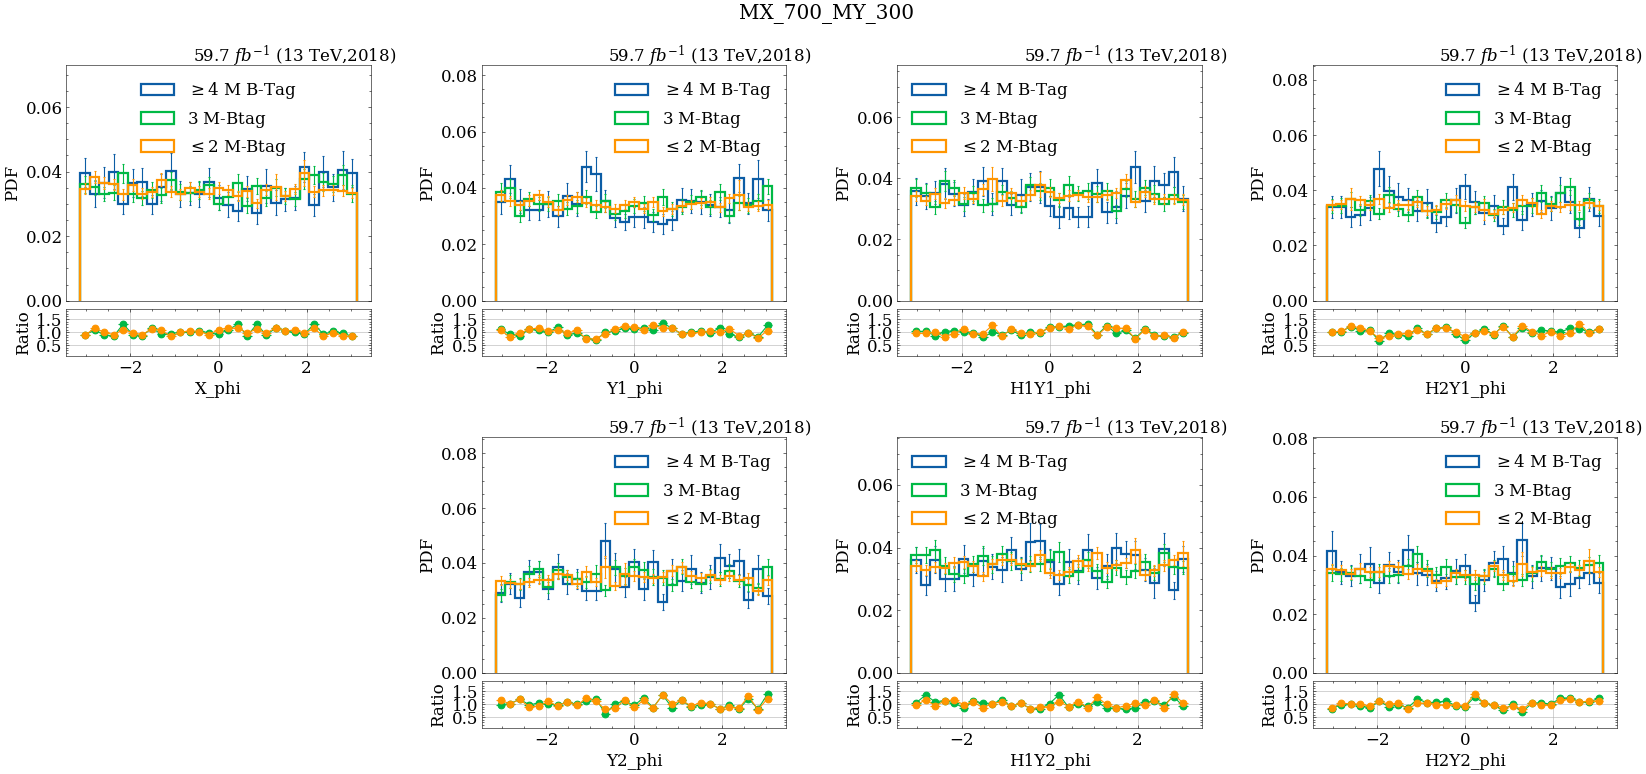

In [60]:
study.quick(
    signaltrees[[0,0,0]],legend=True,title=signaltrees[0].sample,
    masks = [geq4_mbtag, eq3_mbtag, leq2_mbtag],
    h_color=None, label=['$\geq 4$ M B-Tag','$3$ M-Btag', '$\leq 2$ M-Btag'],
    varlist=['n_medium_btag']
)

for var in ('pt','m','eta','phi'):
    study.quick(
        bkgtrees[[0,0,0]],title=signaltrees[0].sample,legend=True, h_label_stat=None,
        masks = [geq4_mbtag, eq3_mbtag, leq2_mbtag],
        h_color=None, label=['$\geq 4$ M B-Tag','$3$ M-Btag', '$\leq 2$ M-Btag'],
        varlist=[(f'{obj}_{var}' if obj else None) for obj in objlist], dim=(-1,4),
        # varlist=['X_m'],
        density=True,
        ratio=True,r_inv=True,
    )

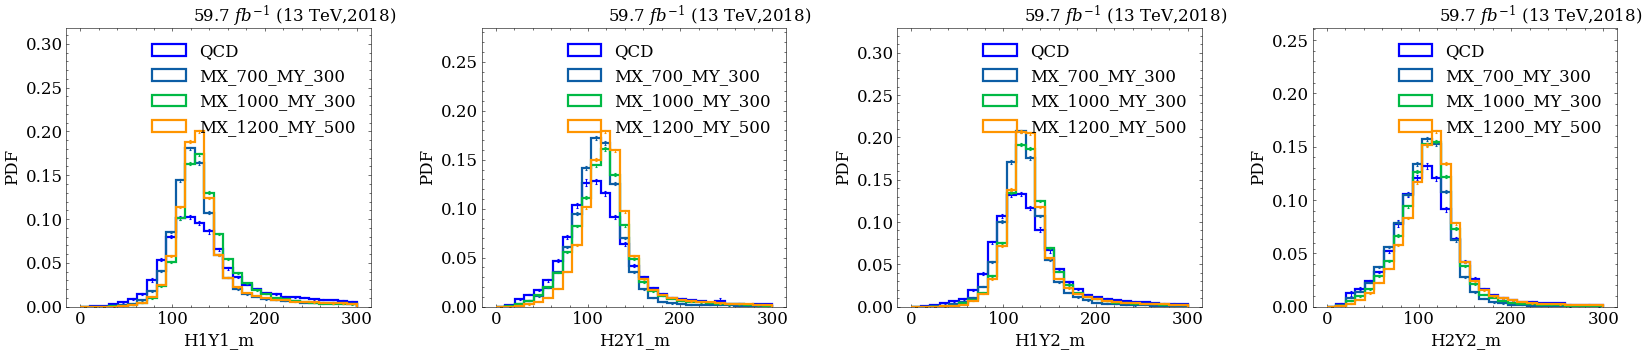

In [62]:
study.quick(
    bkgtrees+signaltrees,
    # masks=lambda t : hm_multi(cut=20)(t) >=3,
    varlist=[f'{obj}_m' for obj in eightb.higgslist ],
    # xlabels=['N $|m_H-125|<20$'],
    density=True,
    dim=(-1,4),
    legend=True,h_label_stat=None,
)

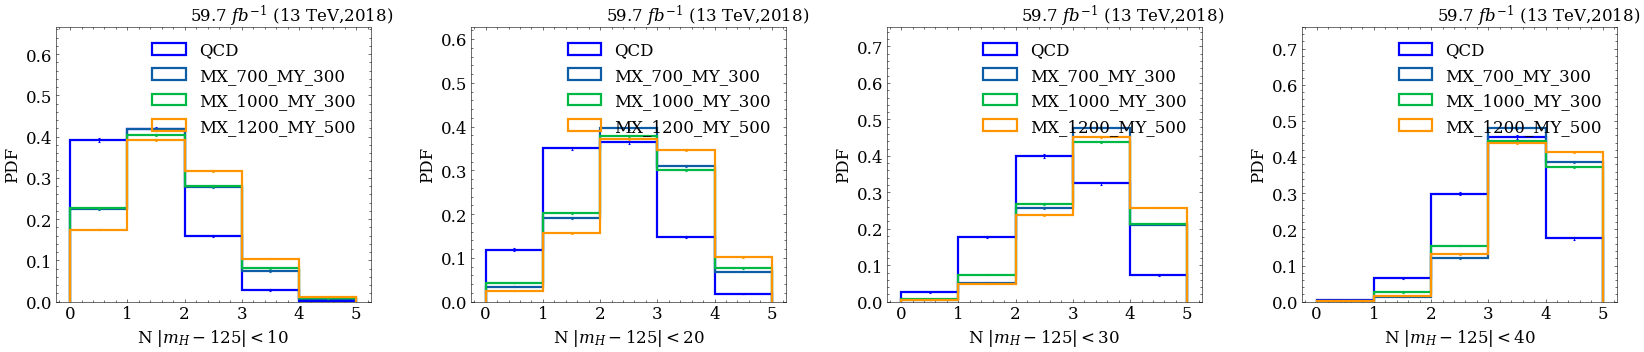

In [70]:
class hm_multi(ObjTransform):
    def __call__(self, t):
        return np.sum(np.abs(t.higgs_m-125) < self.cut,axis=-1)

hm_regions = {f"N $|m_H-125| < {cut}$": hm_multi(cut=cut) for cut in (10,20,30,40) }

study.quick(
    bkgtrees+signaltrees,
    # transforms=np.abs,
    # masks=[lambda t : t.n_medium_btag >= 4, lambda t : t.n_medium_btag < 4],
    varlist=hm_regions.values(),
    xlabels=hm_regions.keys(),
    density=True,
    # binlist=[np.linspace(0,8,30),np.linspace(-6,6,30)],
    legend=True,h_label_stat=None,
    dim=(-1,4),
    
    # cumulative=-1,
    # correlation=1,
)

In [65]:
def build_hm_multi(tree):
    var_func = hm_multi(cut=30)
    tree.extend(**{"N $|m_H-125| < 30$":var_func(tree)})
(bkgtrees+signaltrees).apply(build_hm_multi)

[None, None, None, None]

In [66]:
geq3_hm = lambda t : t["N $|m_H-125| < 30$"] >= 3
leq2_hm = lambda t : t["N $|m_H-125| < 30$"] <= 2

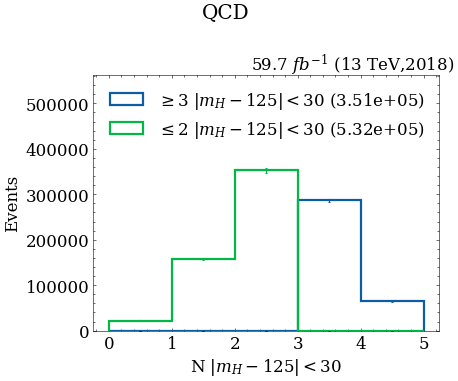

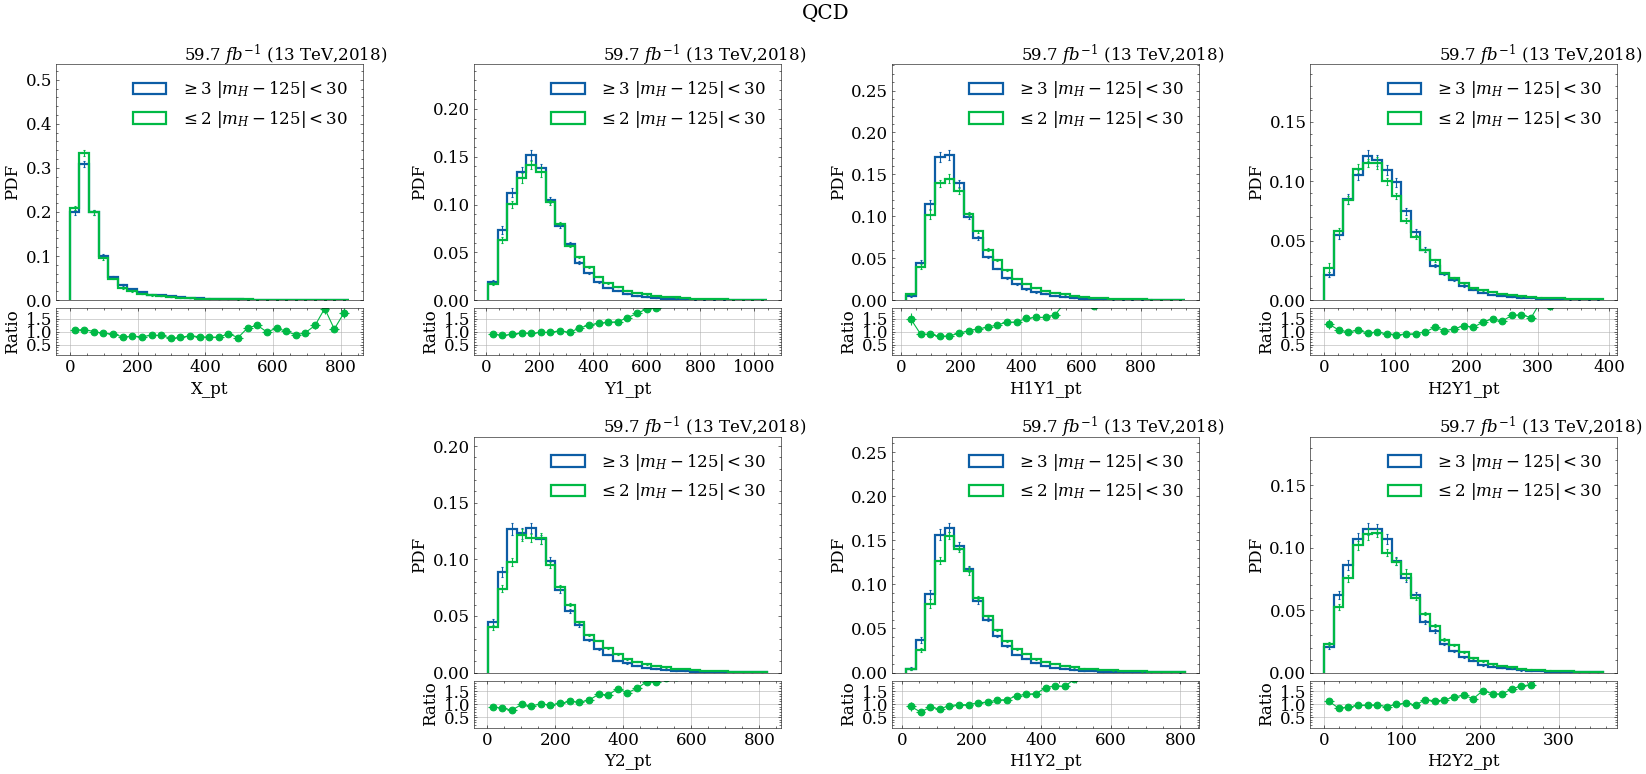

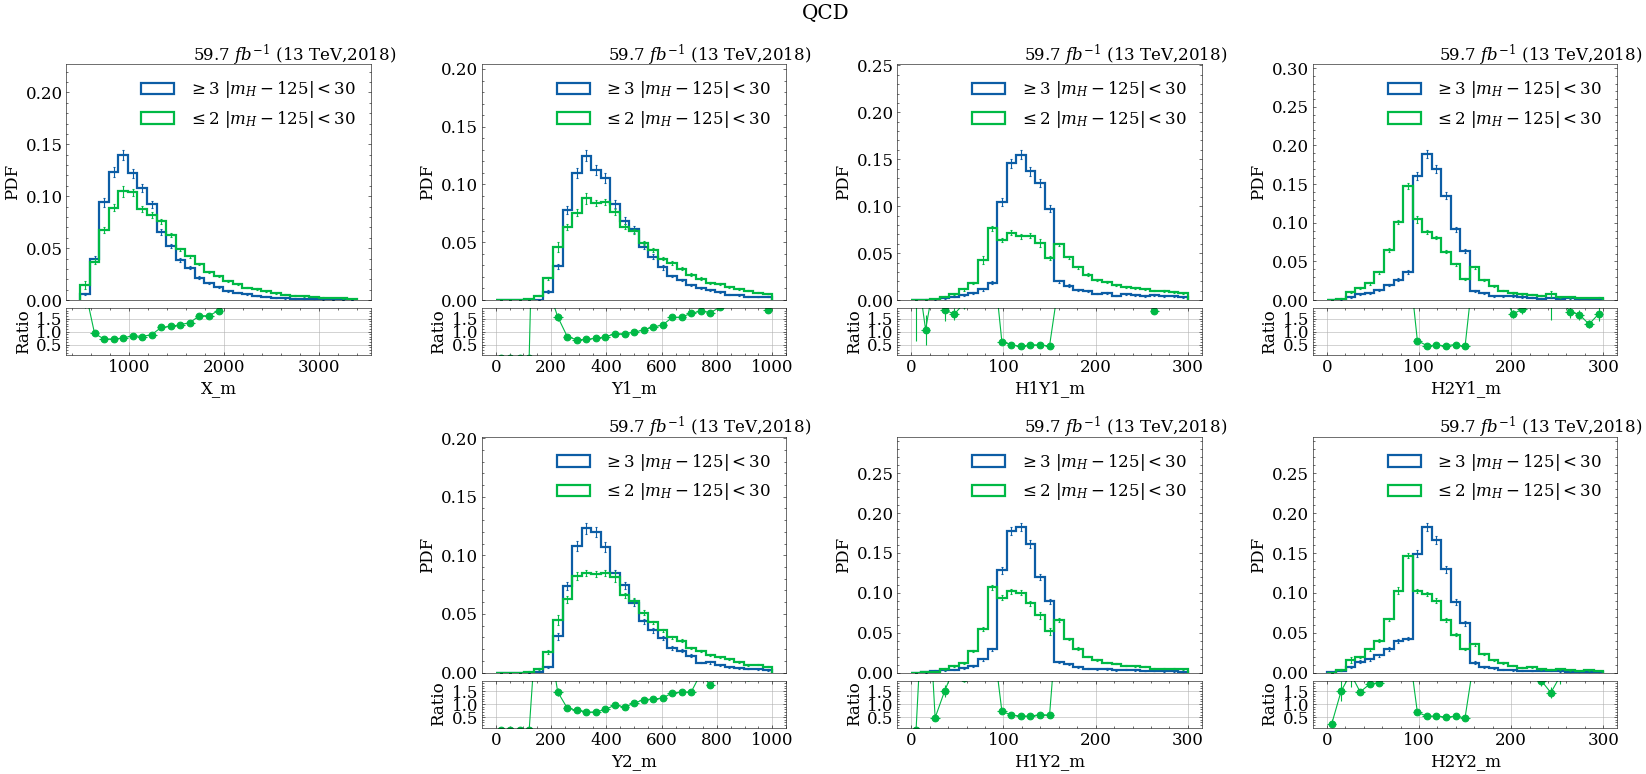

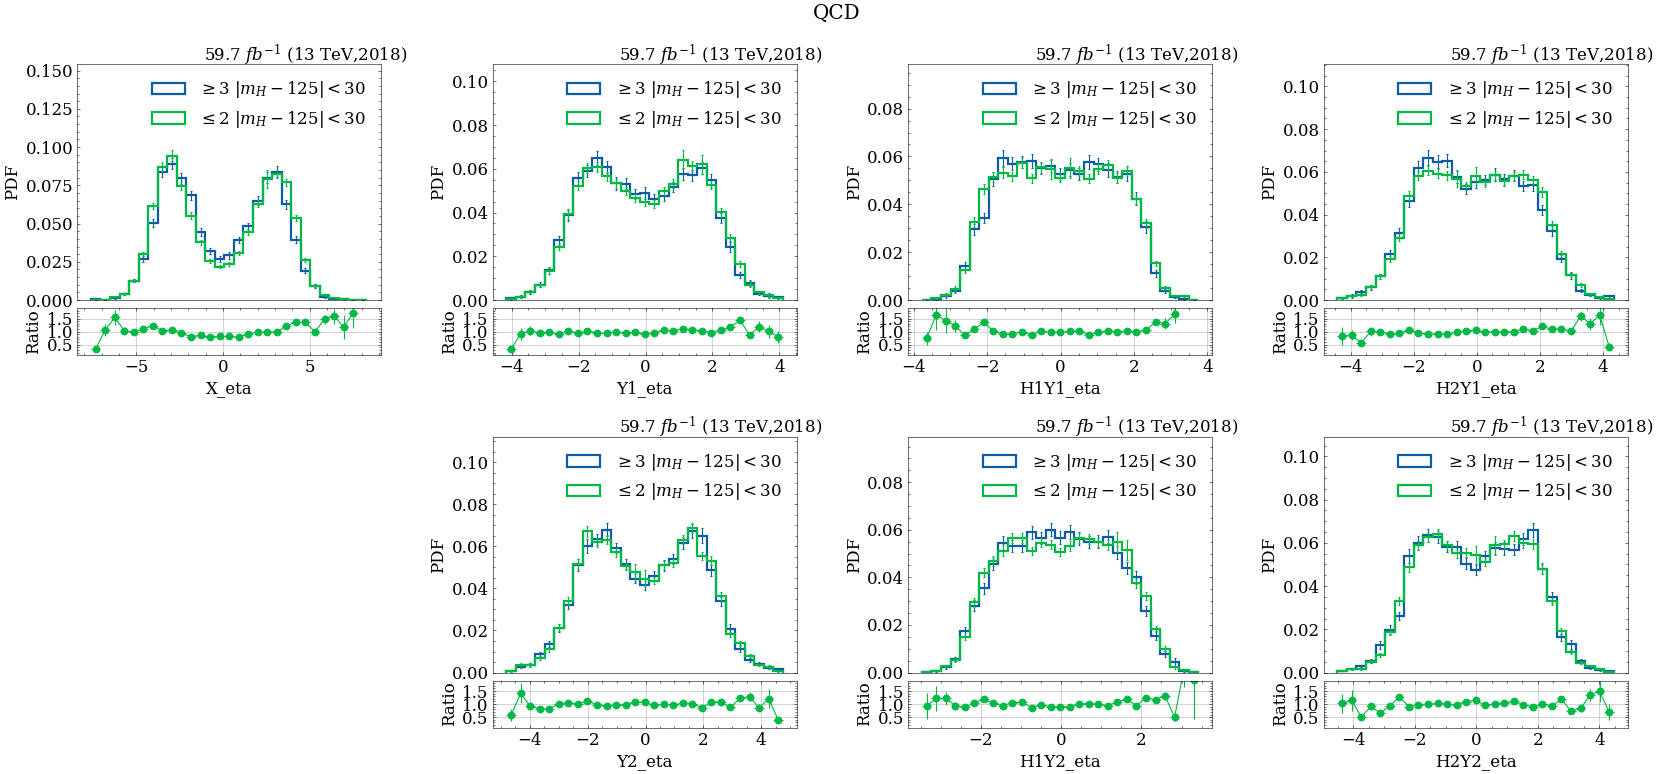

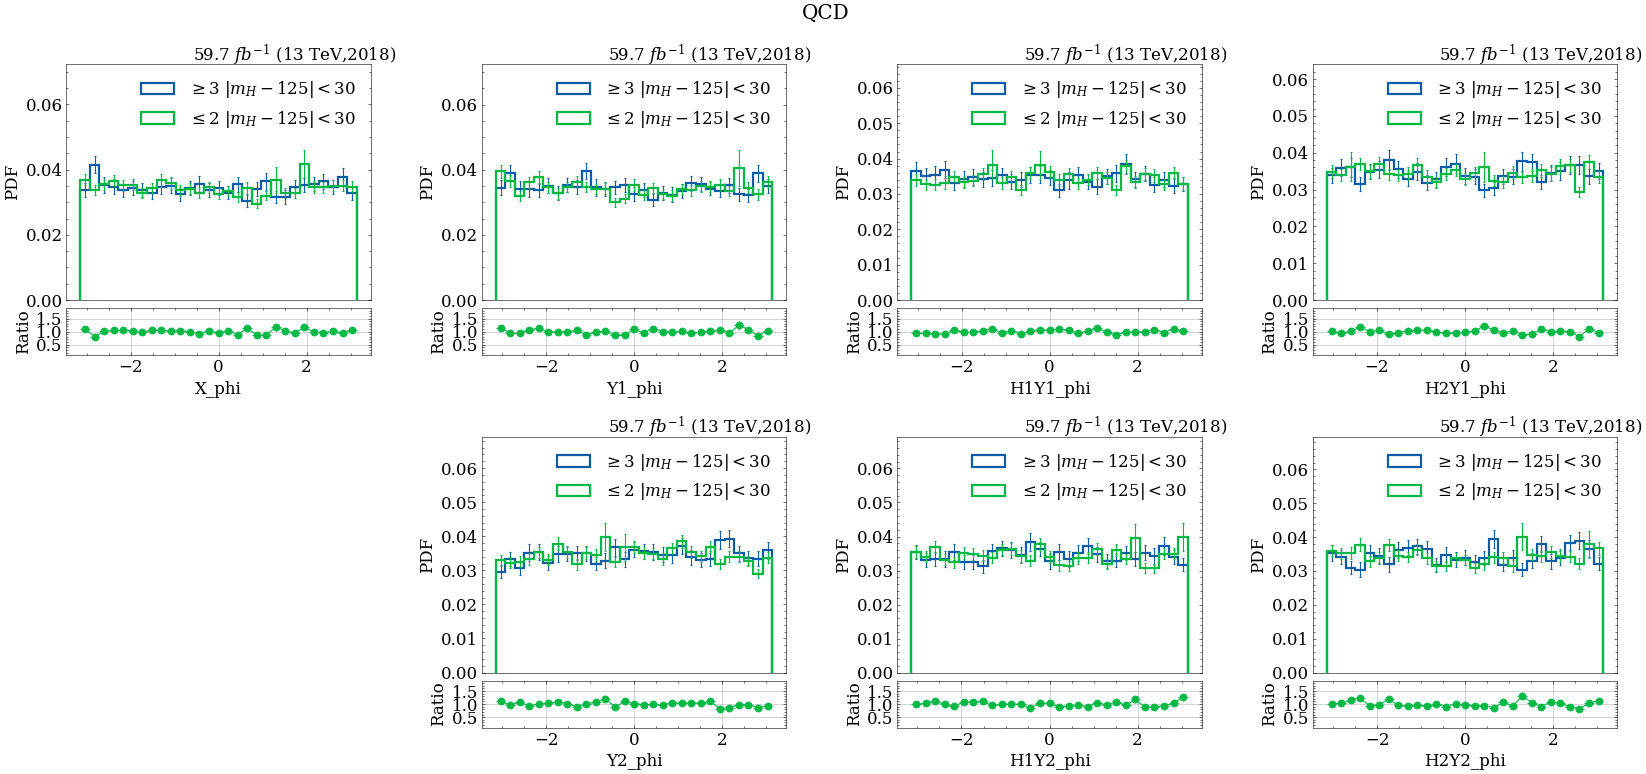

In [68]:
study.quick(
    bkgtrees[[0,0]],legend=True,title='QCD',
    masks = [geq3_hm, leq2_hm],
    h_color=None, label=['$\geq 3$ $|m_H-125| < 30$', '$\leq 2$ $|m_H-125| < 30$'],
    varlist=['N $|m_H-125| < 30$']
)

for var in ('pt','m','eta','phi'):
    study.quick(
        bkgtrees[[0,0,0]],title='QCD',legend=True, h_label_stat=None,
        masks = [geq3_hm, leq2_hm],
        h_color=None, label=['$\geq 3$ $|m_H-125| < 30$', '$\leq 2$ $|m_H-125| < 30$'],
        varlist=[(f'{obj}_{var}' if obj else None) for obj in objlist], dim=(-1,4),
        # varlist=['X_m'],
        density=True,
        ratio=True,r_inv=True,
    )

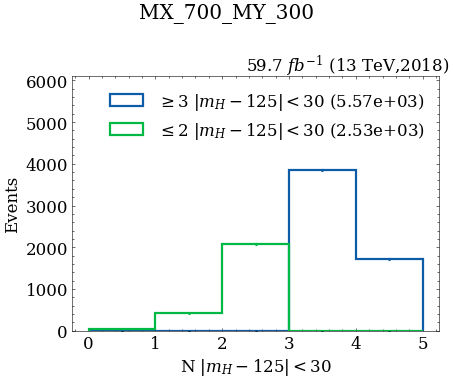

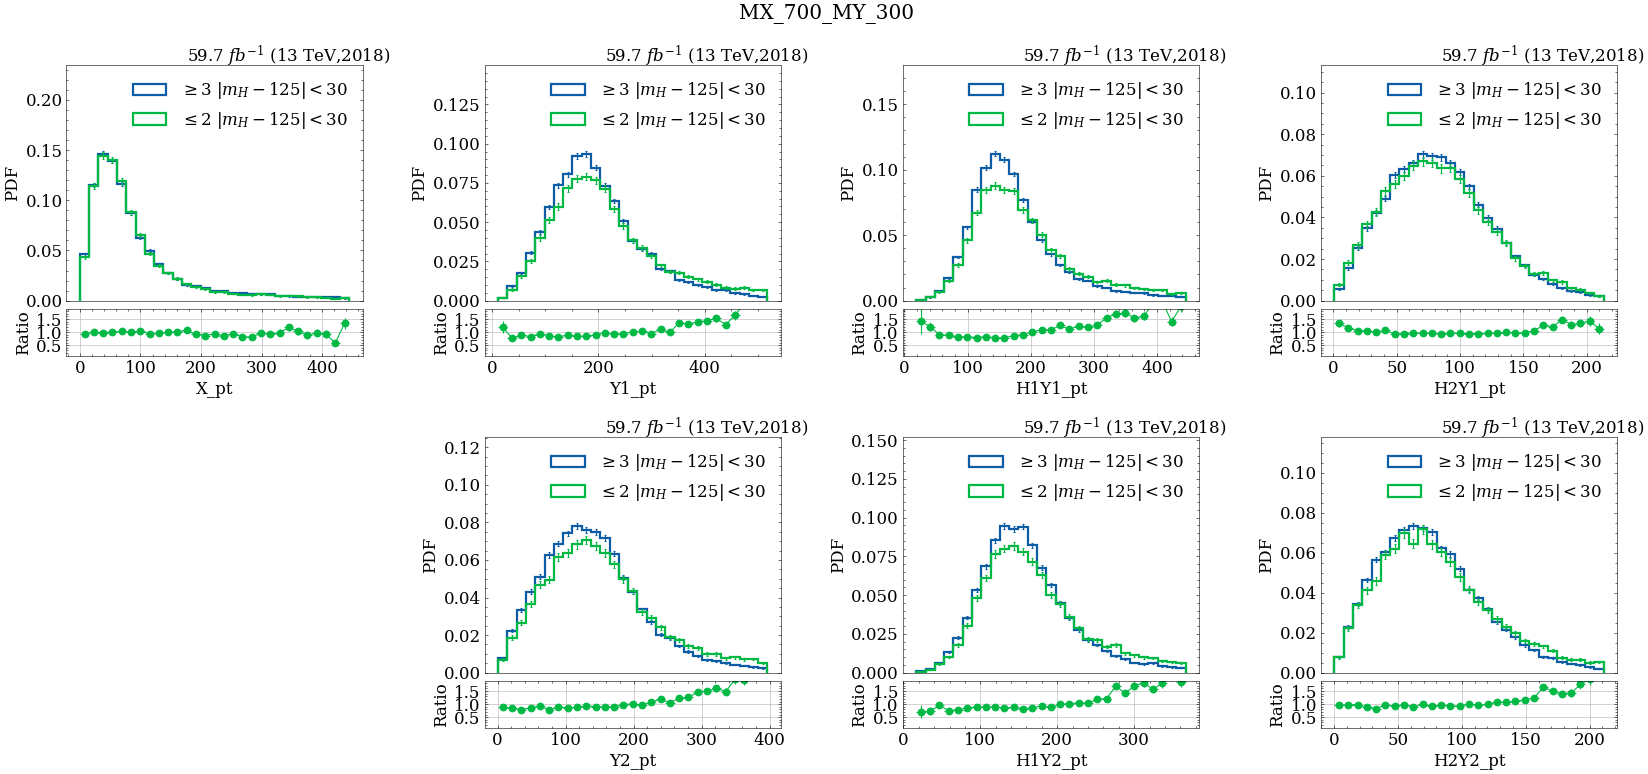

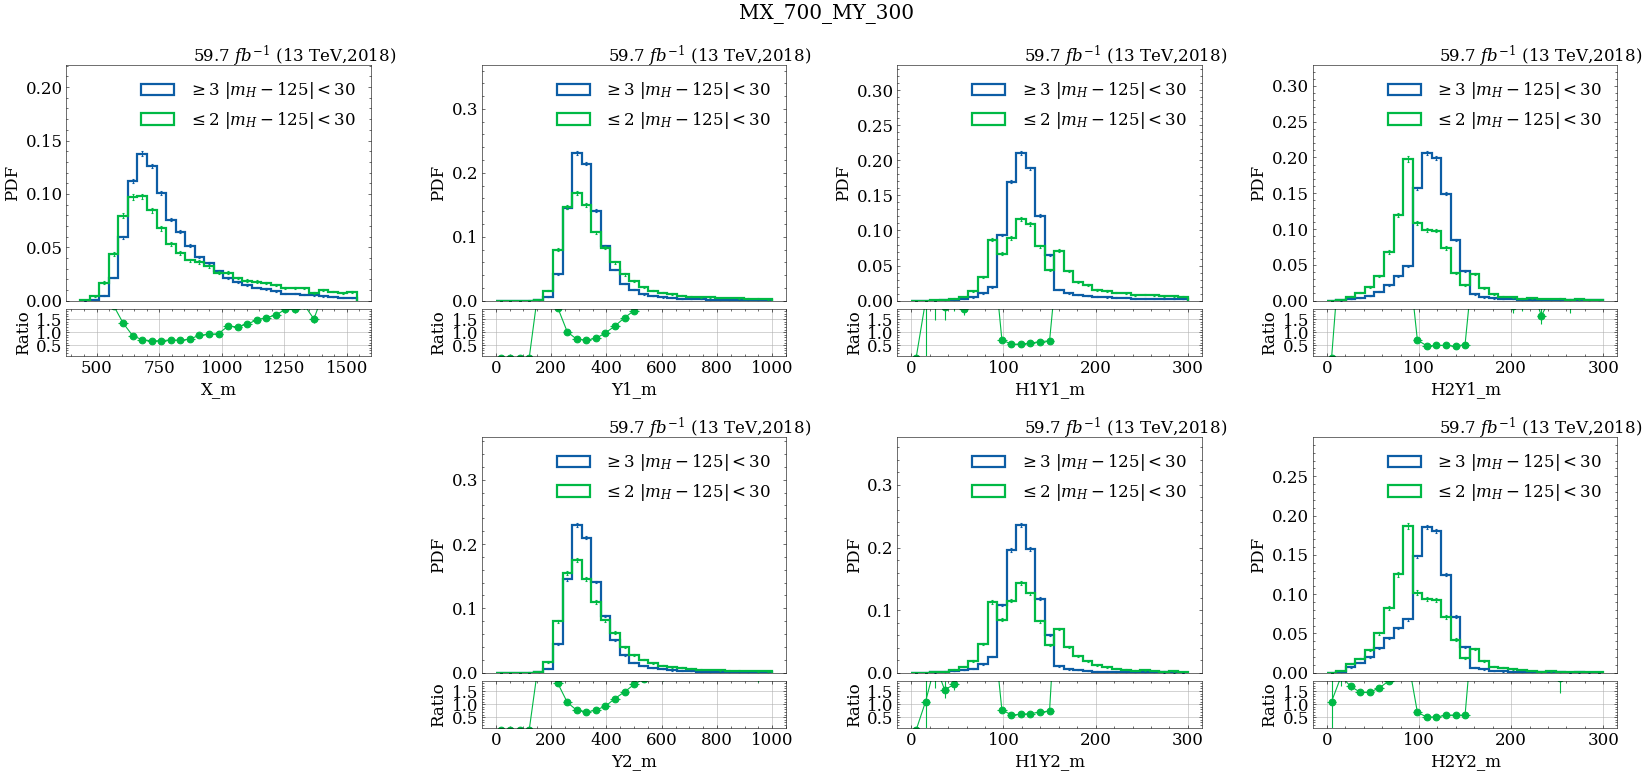

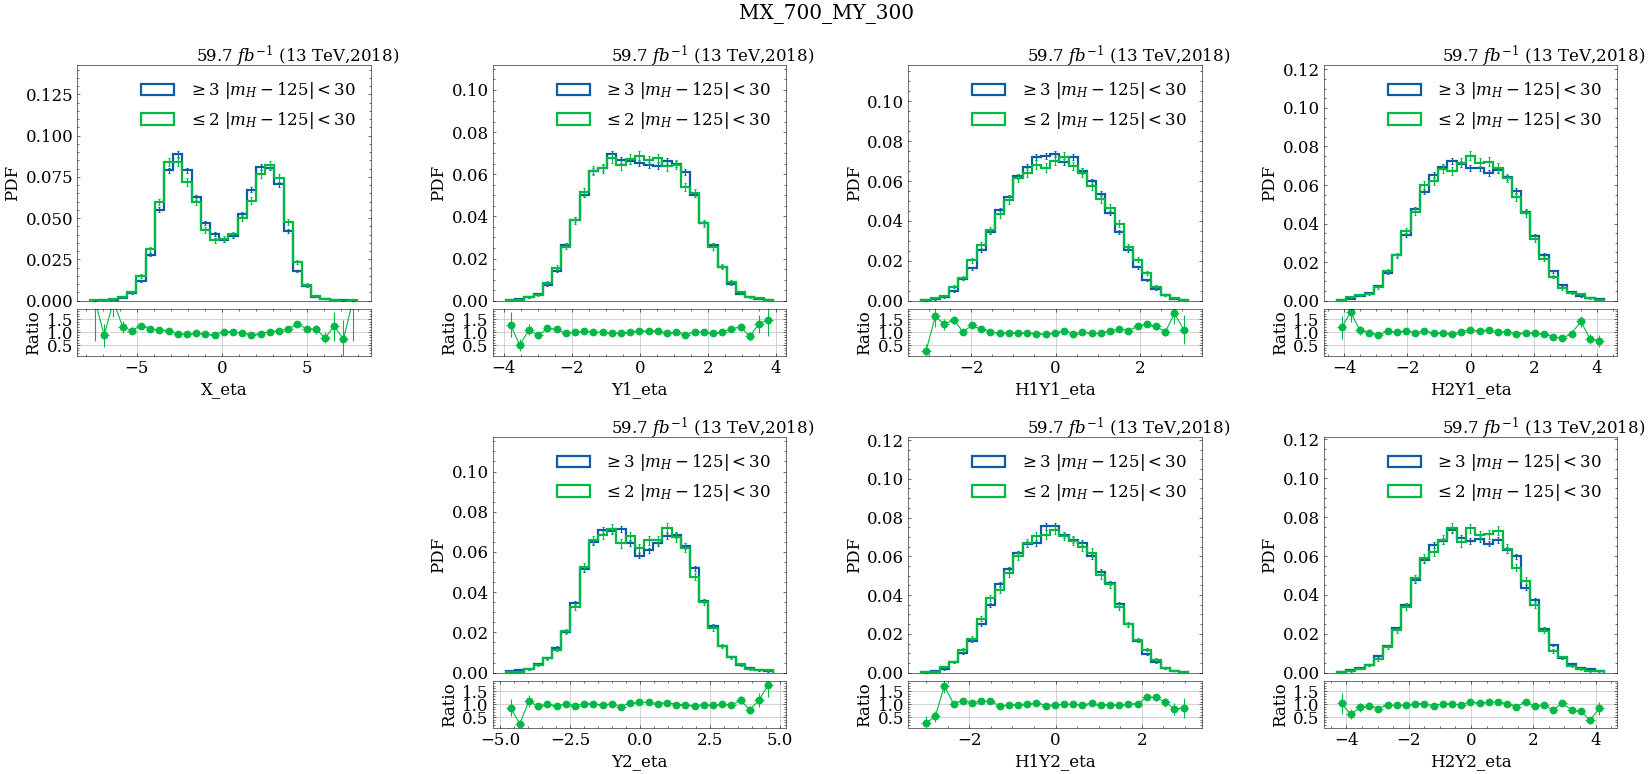

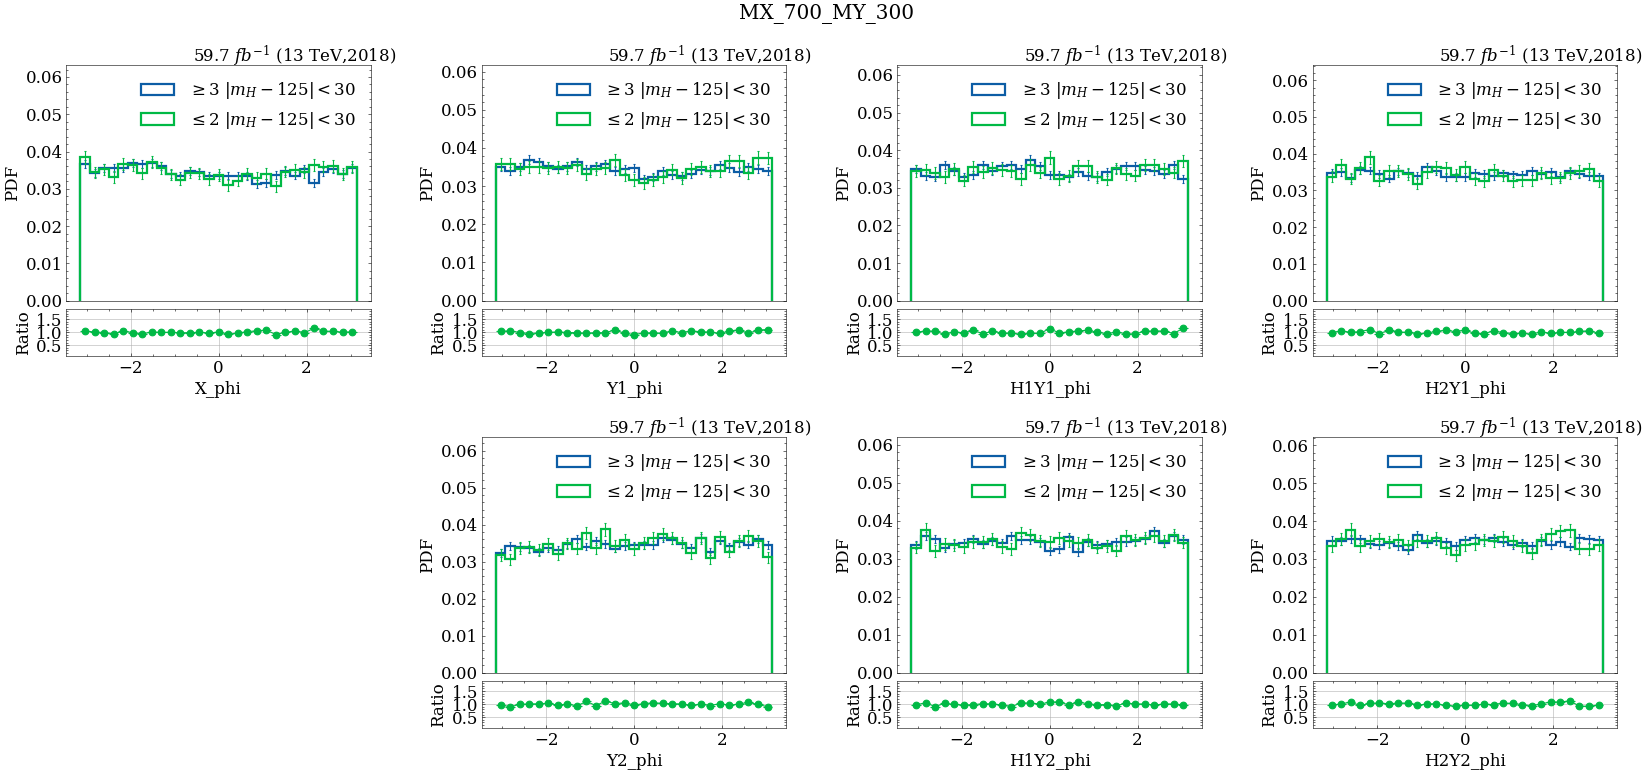

In [69]:
study.quick(
    signaltrees[[0,0]],legend=True,title=signaltrees[0].sample,
    masks = [geq3_hm, leq2_hm],
    h_color=None, label=['$\geq 3$ $|m_H-125| < 30$', '$\leq 2$ $|m_H-125| < 30$'],
    varlist=['N $|m_H-125| < 30$']
)

for var in ('pt','m','eta','phi'):
    study.quick(
        signaltrees[[0,0,0]],title=signaltrees[0].sample,legend=True, h_label_stat=None,
        masks = [geq3_hm, leq2_hm],
        h_color=None, label=['$\geq 3$ $|m_H-125| < 30$', '$\leq 2$ $|m_H-125| < 30$'],
        varlist=[(f'{obj}_{var}' if obj else None) for obj in objlist], dim=(-1,4),
        # varlist=['X_m'],
        density=True,
        ratio=True,r_inv=True,
    )

In [53]:
var_asym = lambda x,y : (x-y)/(x+y)
var_diff = lambda x,y : x-y

def var_diffs(var):
    nobj = ak.count(var,axis=-1)[0]
    return ak.concatenate([ var_diff(var[:,i],var[:,j])[:,None] for i in range(nobj) for j in range(i+1, nobj) ],axis=-1)

def var_asyms(var):
    nobj = ak.count(var,axis=-1)[0]
    return ak.concatenate([ var_asym(var[:,i],var[:,j])[:,None] for i in range(nobj) for j in range(i+1, nobj) ],axis=-1)

def dphis(phis):
    nobj = ak.count(phis,axis=-1)[0]
    return ak.concatenate([ calc_dphi(phis[:,i],phis[:,j])[:,None] for i in range(nobj) for j in range(i+1, nobj) ],axis=-1)
    
def y_diffs(tree):
    y_deta = var_diffs(tree.y_eta)
    
    y_dphi = dphis(tree.y_phi)
                                
    y_dr = np.sqrt( y_deta**2+y_dphi**2) 
     
    y_dm = var_asyms(tree.y_m)
    
    y_dpt = var_asyms(tree.y_pt)
    
    tree.extend(**{ key:value for key,value in locals().items() if isinstance(value, ak.Array)})


def higgs_diffs(tree):
    hij_deta = var_diffs(tree.higgs_eta)
    h_detasum = np.sqrt( np.sum(hij_deta**2,axis=-1) )
    
    hij_dphi = dphis(tree.higgs_phi)
    h_dphisum = np.sqrt( np.sum(hij_dphi**2,axis=-1))
                                
    hij_dr = np.sqrt( hij_deta**2+hij_dphi**2) 
    h_drsum = np.sqrt( np.sum(hij_dr**2,axis=-1))
     
    hij_dm = var_asyms(tree.higgs_m)
    h_dmsum = np.sqrt(np.sum(hij_dm**2,axis=-1))
    
    hij_dpt = var_asyms(tree.higgs_pt)
    h_dptsum = np.sqrt(np.sum(hij_dpt**2,axis=-1))
    
    tree.extend(**{ key:value for key,value in locals().items() if isinstance(value, ak.Array)})


def bjet_diffs(tree):
    bij_deta = var_diffs(tree.bjet_eta)
    b_detasum = np.sqrt( np.sum(bij_deta**2,axis=-1) )
    
    bij_dphi = dphis(tree.bjet_phi)
    b_dphisum = np.sqrt( np.sum(bij_dphi**2,axis=-1))
                                
    bij_dr = np.sqrt( bij_deta**2+bij_dphi**2) 
    b_drsum = np.sqrt( np.sum(bij_dr**2,axis=-1))
     
    bij_dm = var_asyms(tree.bjet_m)
    b_dmsum = np.sqrt(np.sum(bij_dm**2,axis=-1))
    
    bij_dpt = var_asyms(tree.bjet_pt)
    b_dptsum = np.sqrt(np.sum(bij_dpt**2,axis=-1))
    
    tree.extend(**{ key:value for key,value in locals().items() if isinstance(value, ak.Array)})

(bkgtrees+signaltrees).apply(y_diffs)
(bkgtrees+signaltrees).apply(higgs_diffs)
(bkgtrees+signaltrees).apply(bjet_diffs)


[None, None, None, None]

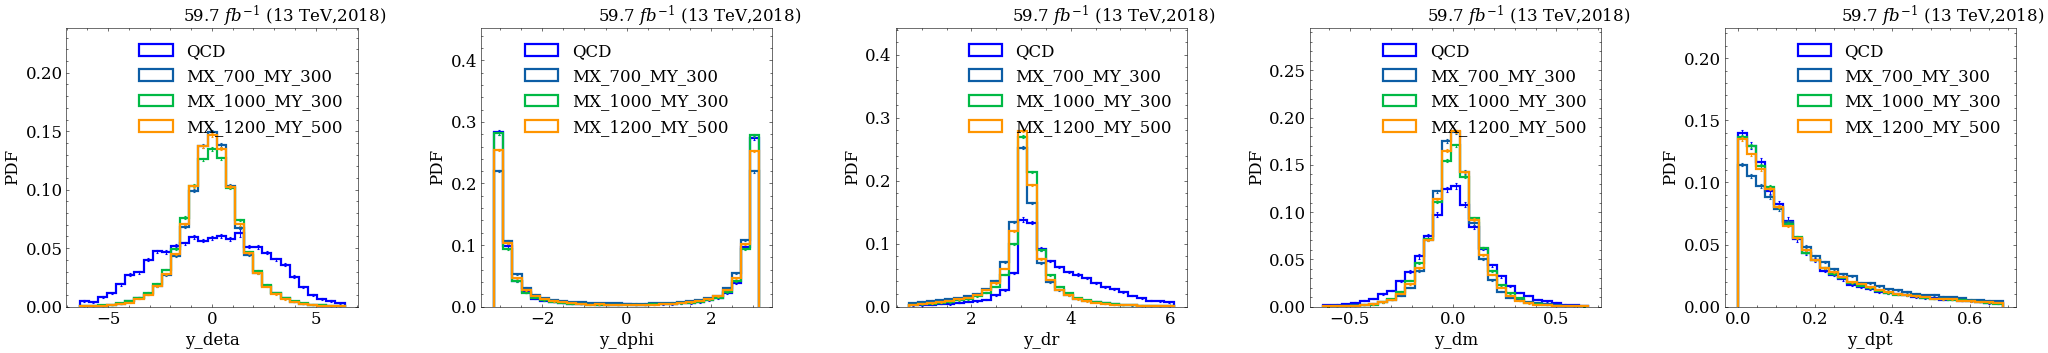

In [54]:
# varinfo.y_dm = dict(bins=np.linspace(-1,1,30))
# varinfo.y_dmsum = dict(bins=np.linspace(0,2,30))

study.quick(
    bkgtrees+signaltrees,
    # transforms=np.abs,
    varlist=[
        'y_deta','y_dphi','y_dr','y_dm','y_dpt',
    ],
    density=True, 
    # binlist=[np.linspace(0,8,30),np.linspace(-6,6,30)],
    dim=(-1,5),legend=True,h_label_stat=None,
    
    # cumulative=1,
    # correlation=1,
)

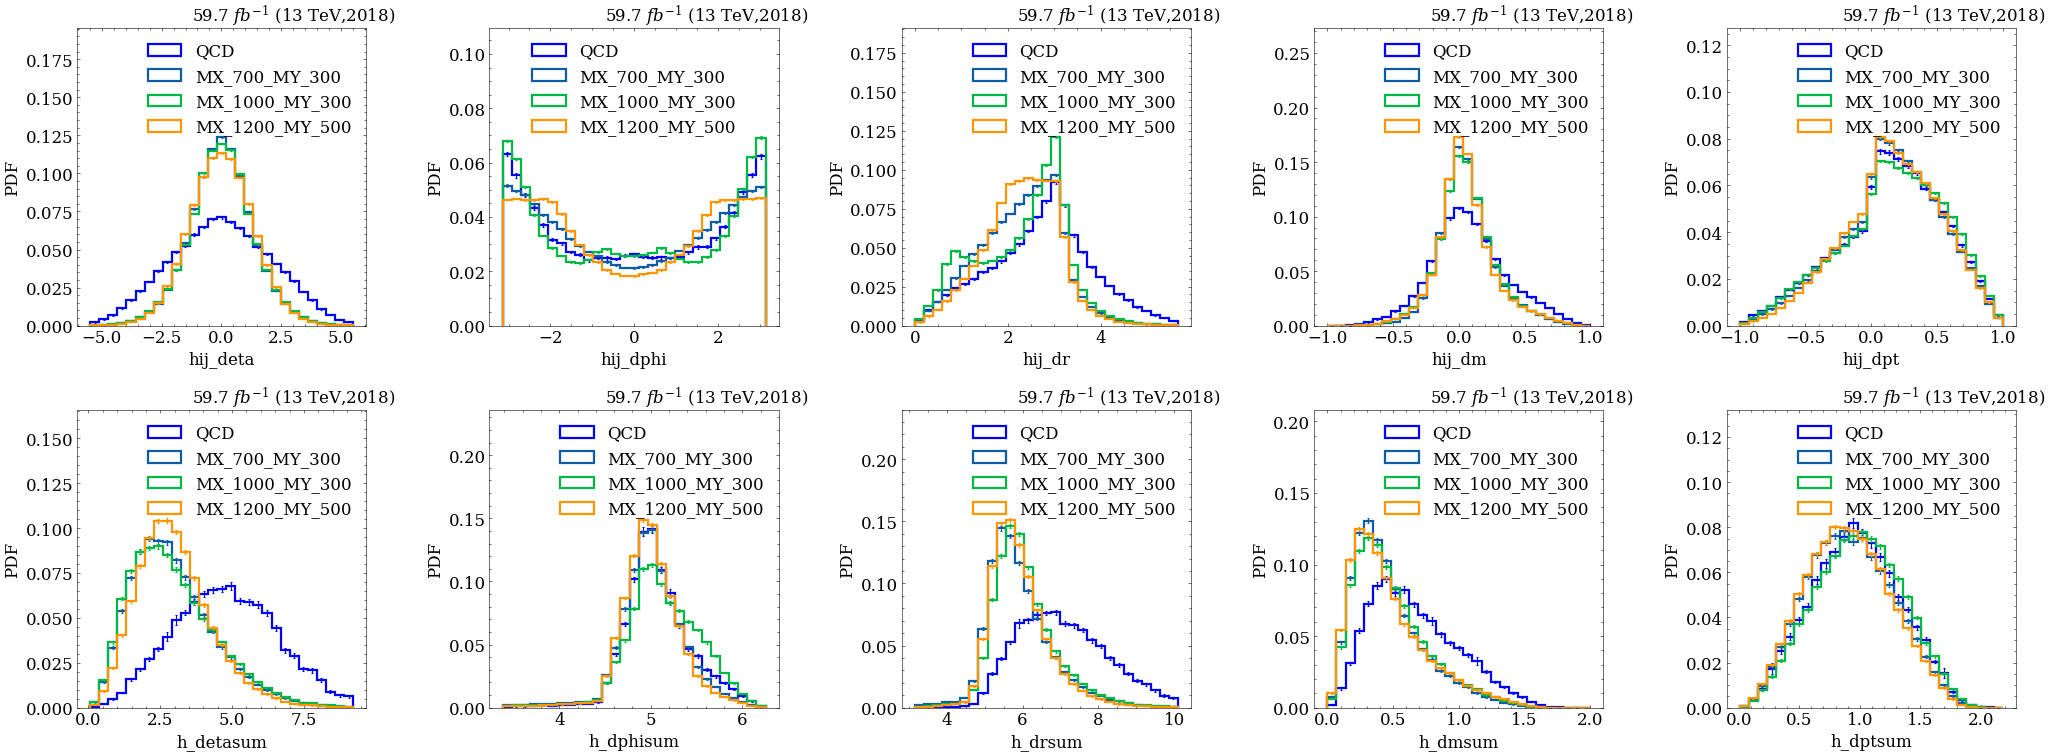

In [50]:
varinfo.hij_dm = dict(bins=np.linspace(-1,1,30))
varinfo.h_dmsum = dict(bins=np.linspace(0,2,30))

study.quick(
    bkgtrees+signaltrees,
    # transforms=np.abs,
    varlist=[
        'hij_deta','hij_dphi','hij_dr','hij_dm','hij_dpt',
        'h_detasum','h_dphisum','h_drsum','h_dmsum','h_dptsum'
    ],
    density=True, 
    # binlist=[np.linspace(0,8,30),np.linspace(-6,6,30)],
    dim=(-1,5),legend=True,h_label_stat=None,
    
    # cumulative=1,
    # correlation=1,
)

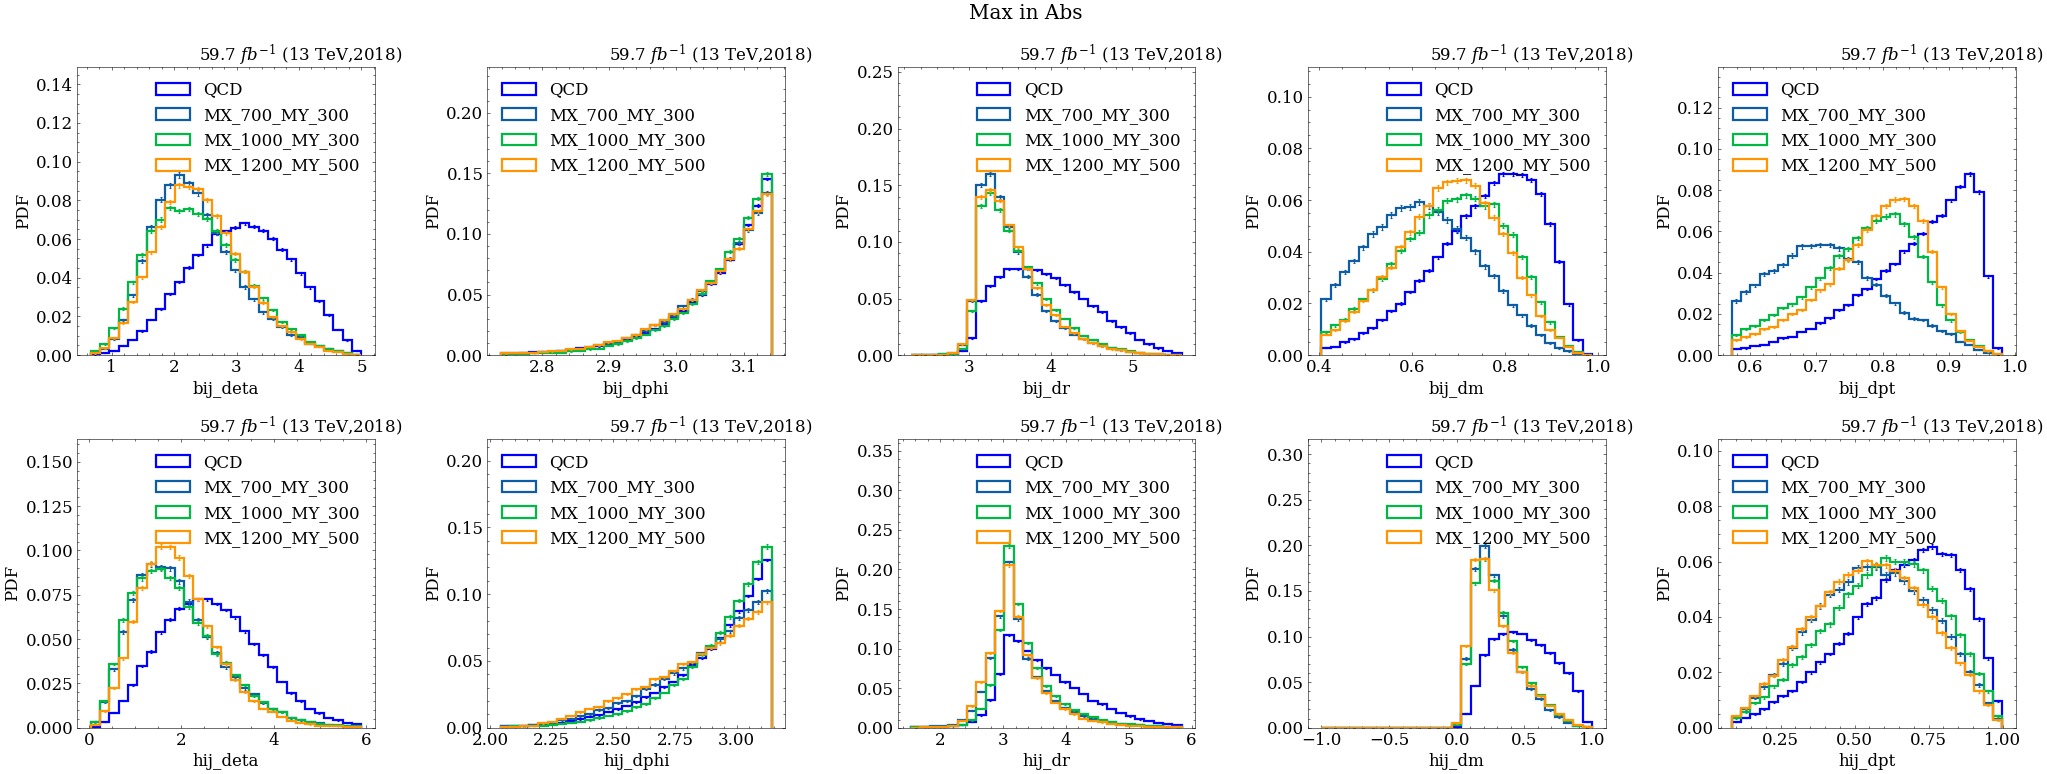

In [71]:

study.quick(
    bkgtrees+signaltrees,
    transforms=lambda v : np.max( np.abs(v) ,axis=-1),
    varlist=[
        'bij_deta','bij_dphi','bij_dr','bij_dm','bij_dpt',
        'hij_deta','hij_dphi','hij_dr','hij_dm','hij_dpt',
    ],
    density=True, 
    # binlist=[np.linspace(0,8,30),np.linspace(-6,6,30)],
    dim=(-1,5),legend=True,h_label_stat=None,
    title='Max in Abs'
    # cumulative=1,
    # correlation=1,
)

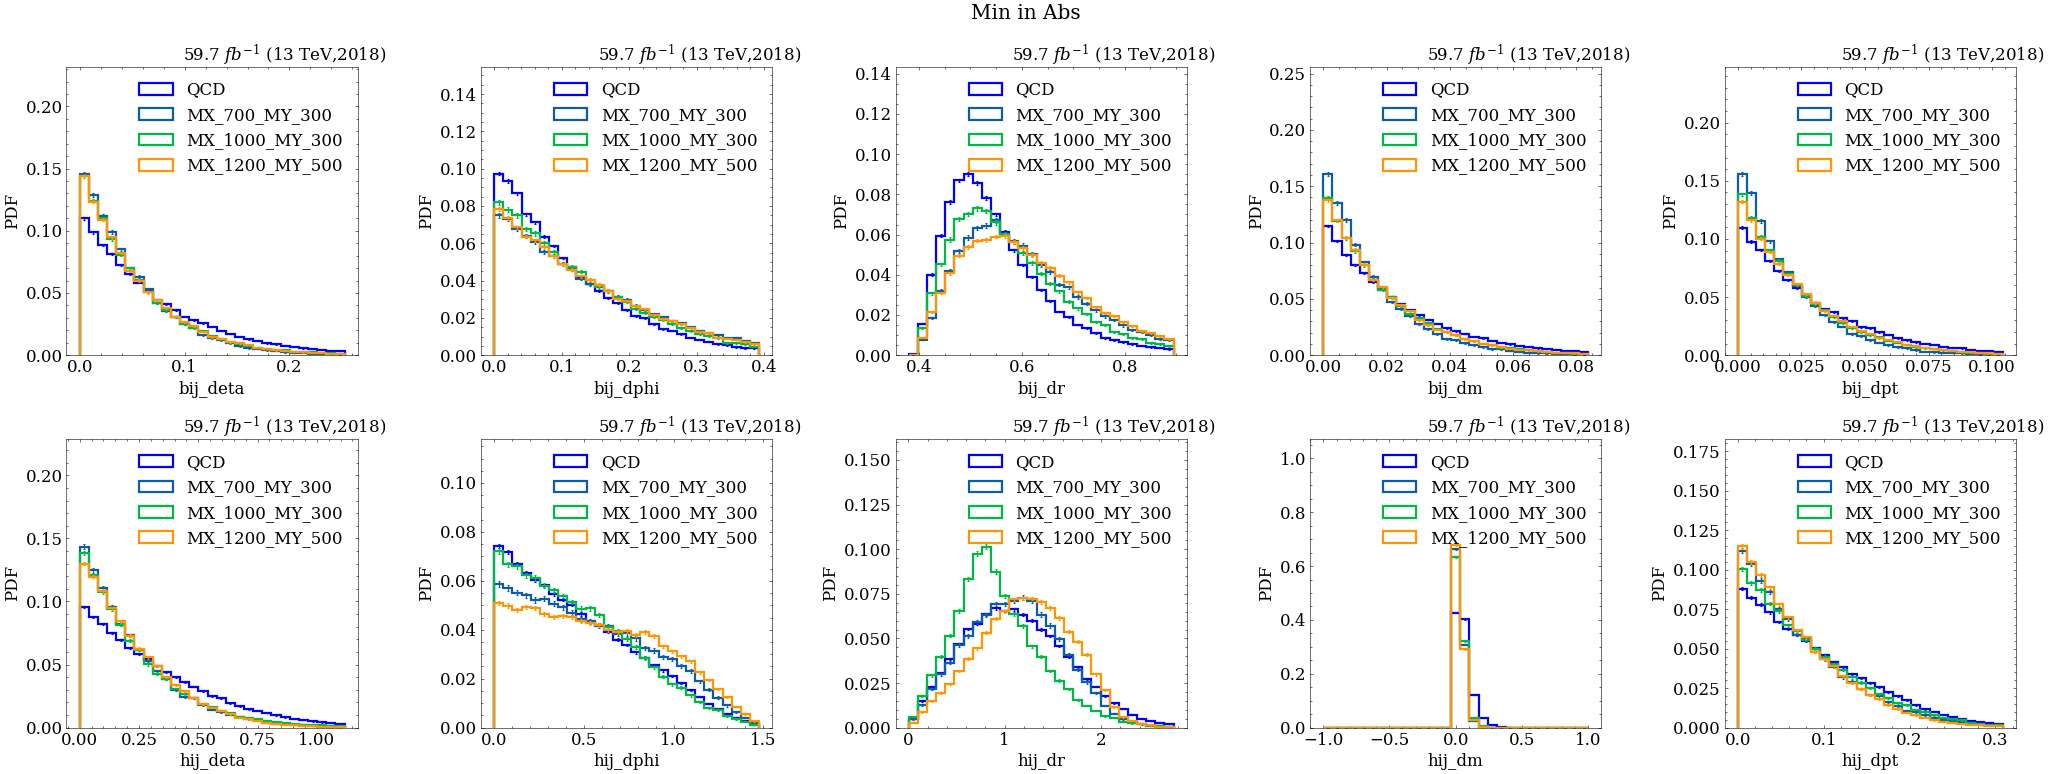

In [72]:

study.quick(
    bkgtrees+signaltrees,
    transforms=lambda v : np.min( np.abs(v) ,axis=-1),
    varlist=[
        'bij_deta','bij_dphi','bij_dr','bij_dm','bij_dpt',
        'hij_deta','hij_dphi','hij_dr','hij_dm','hij_dpt',
    ],
    density=True, 
    # binlist=[np.linspace(0,8,30),np.linspace(-6,6,30)],
    dim=(-1,5),legend=True,h_label_stat=None,
    title='Min in Abs'
    # cumulative=1,
    # correlation=1,
)

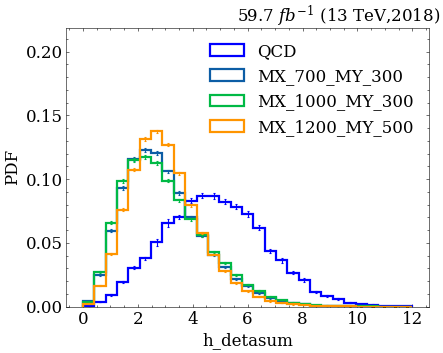

In [73]:
study.quick(
    bkgtrees+signaltrees,
    varlist=['h_detasum'],
    binlist=[np.linspace(0,12,30)],density=True, 
    legend=True,h_label_stat=None,
)

In [74]:
l4_h_detasum = lambda t : t.h_detasum < 4
g4_h_detasum = lambda t : t.h_detasum > 4

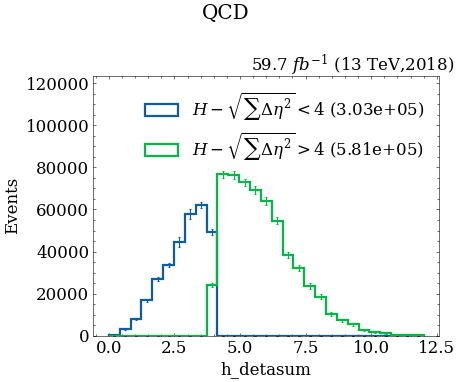

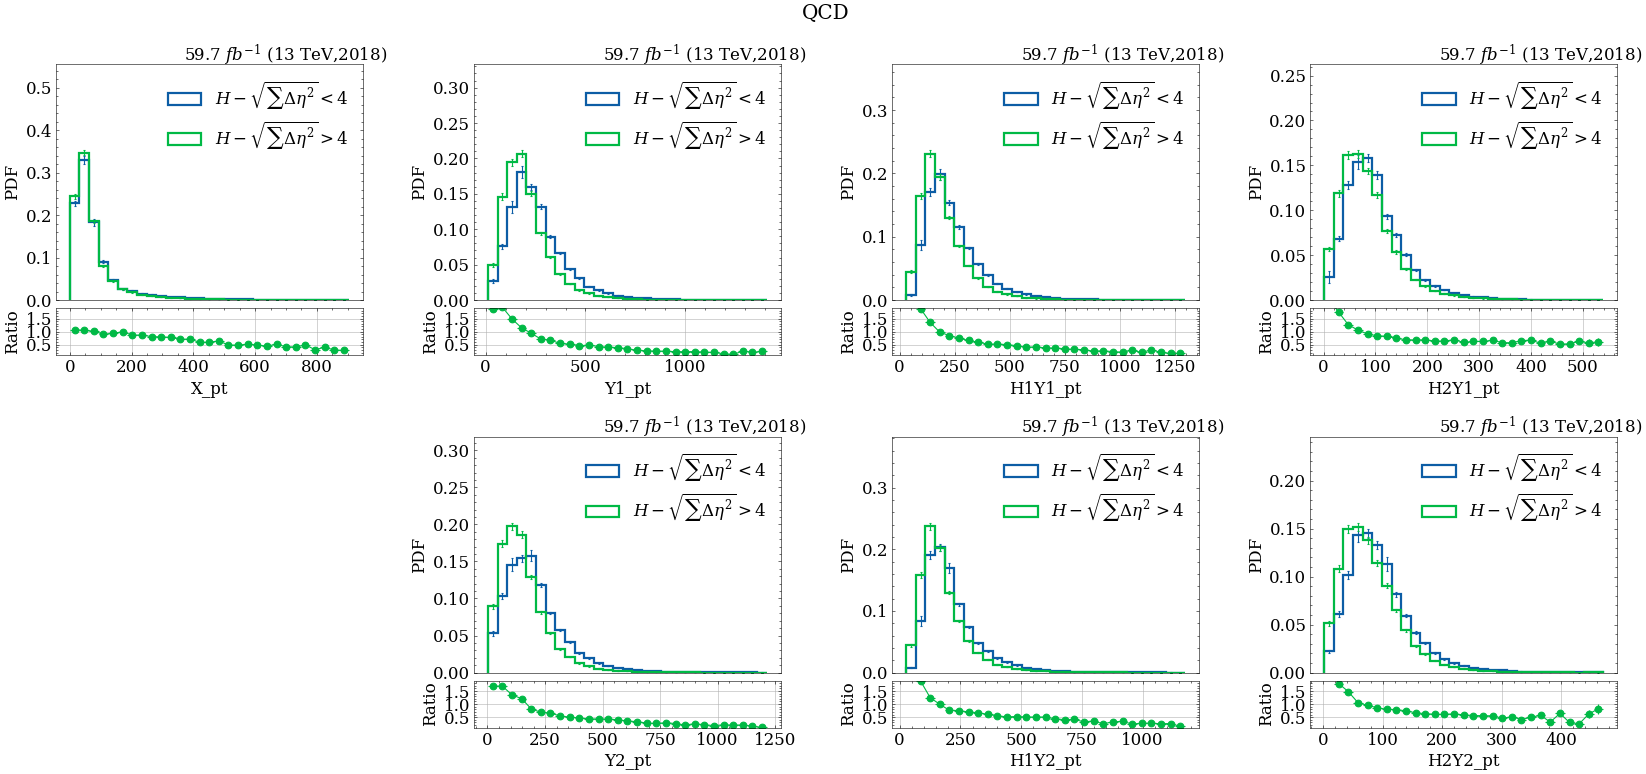

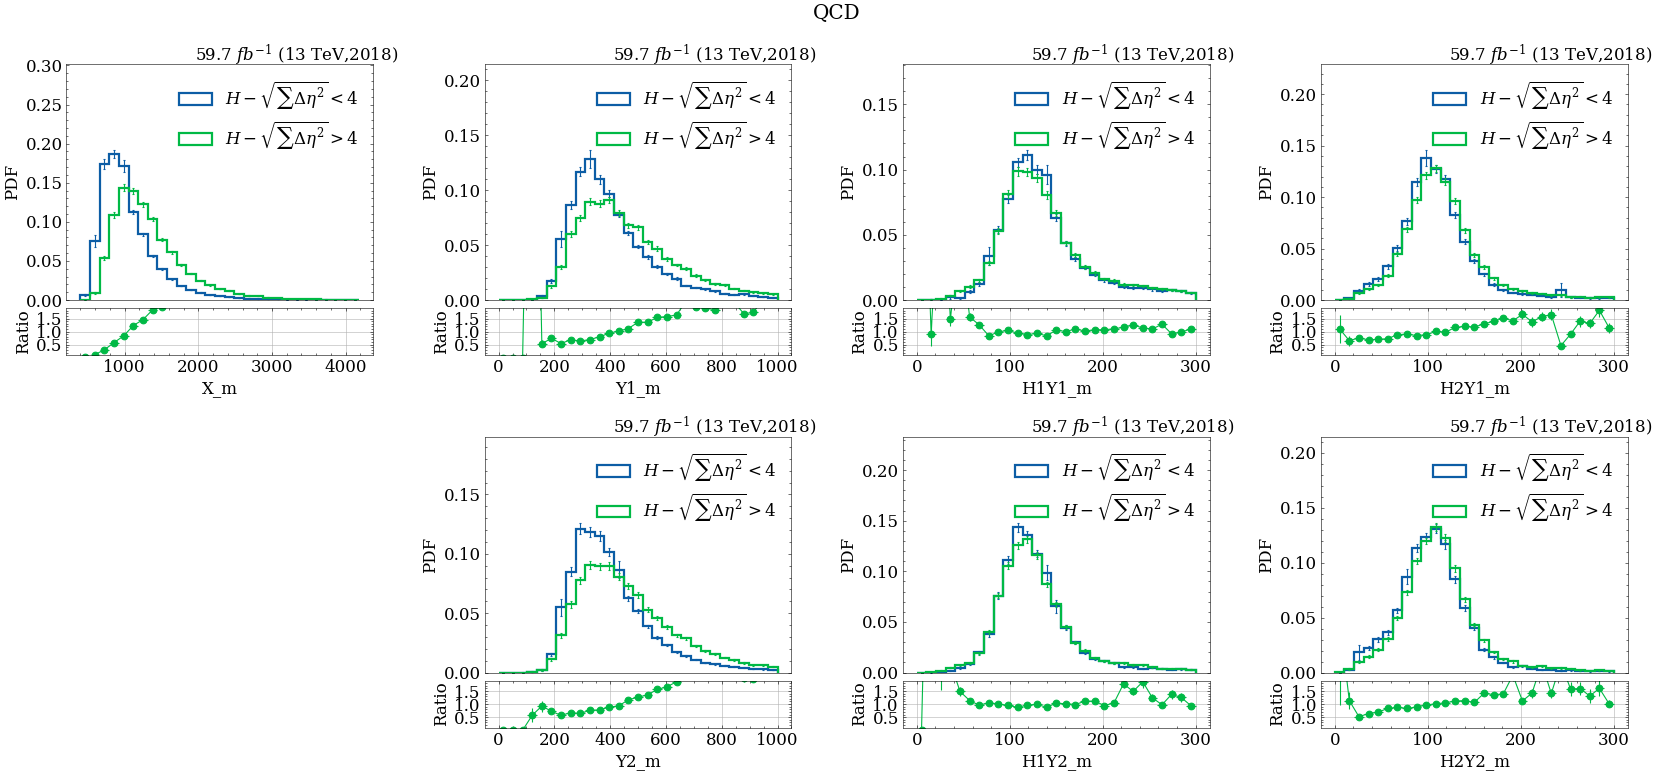

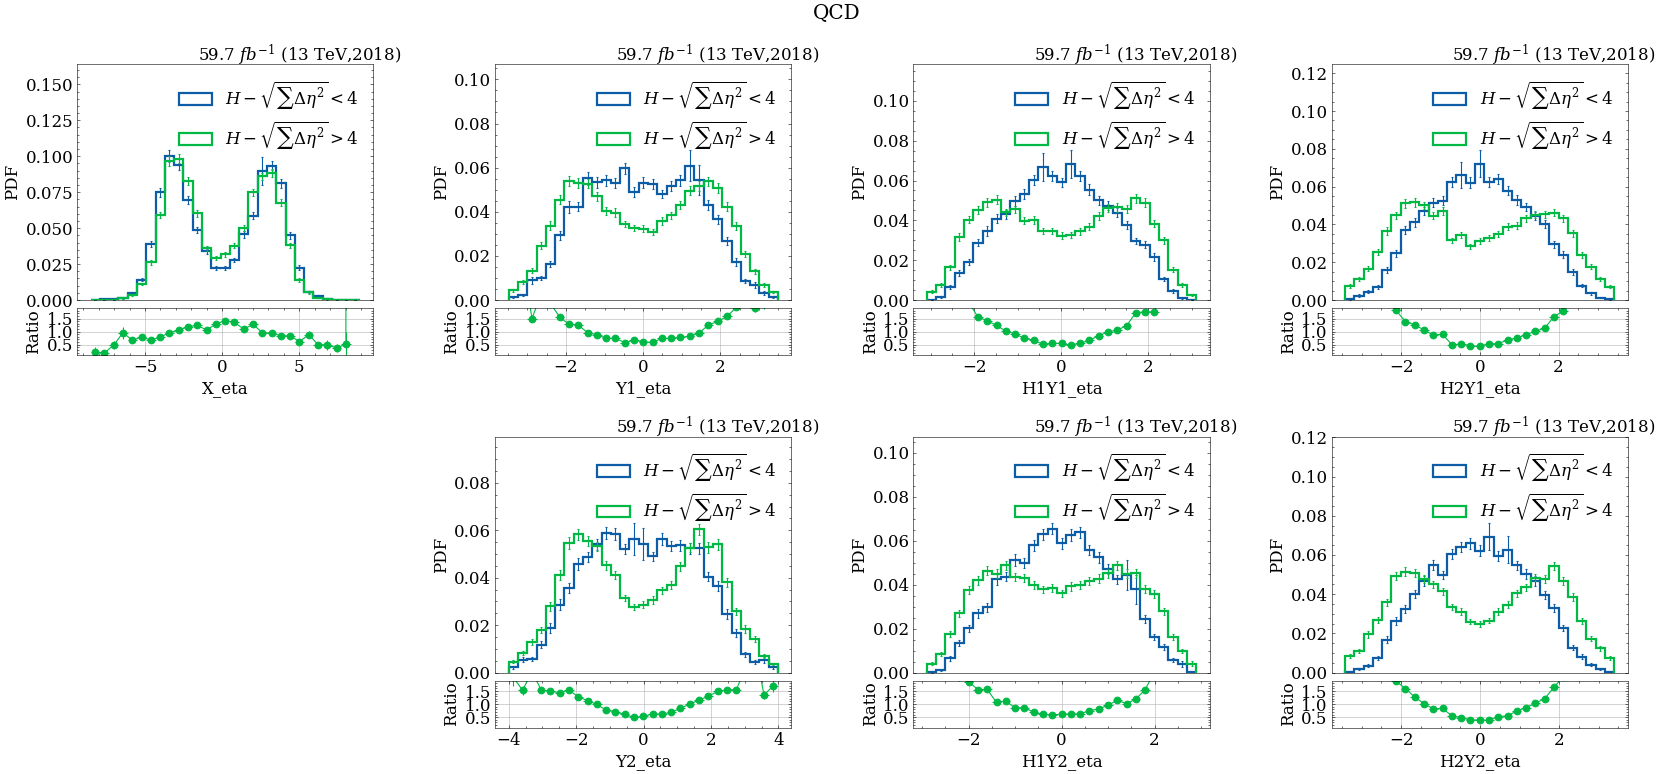

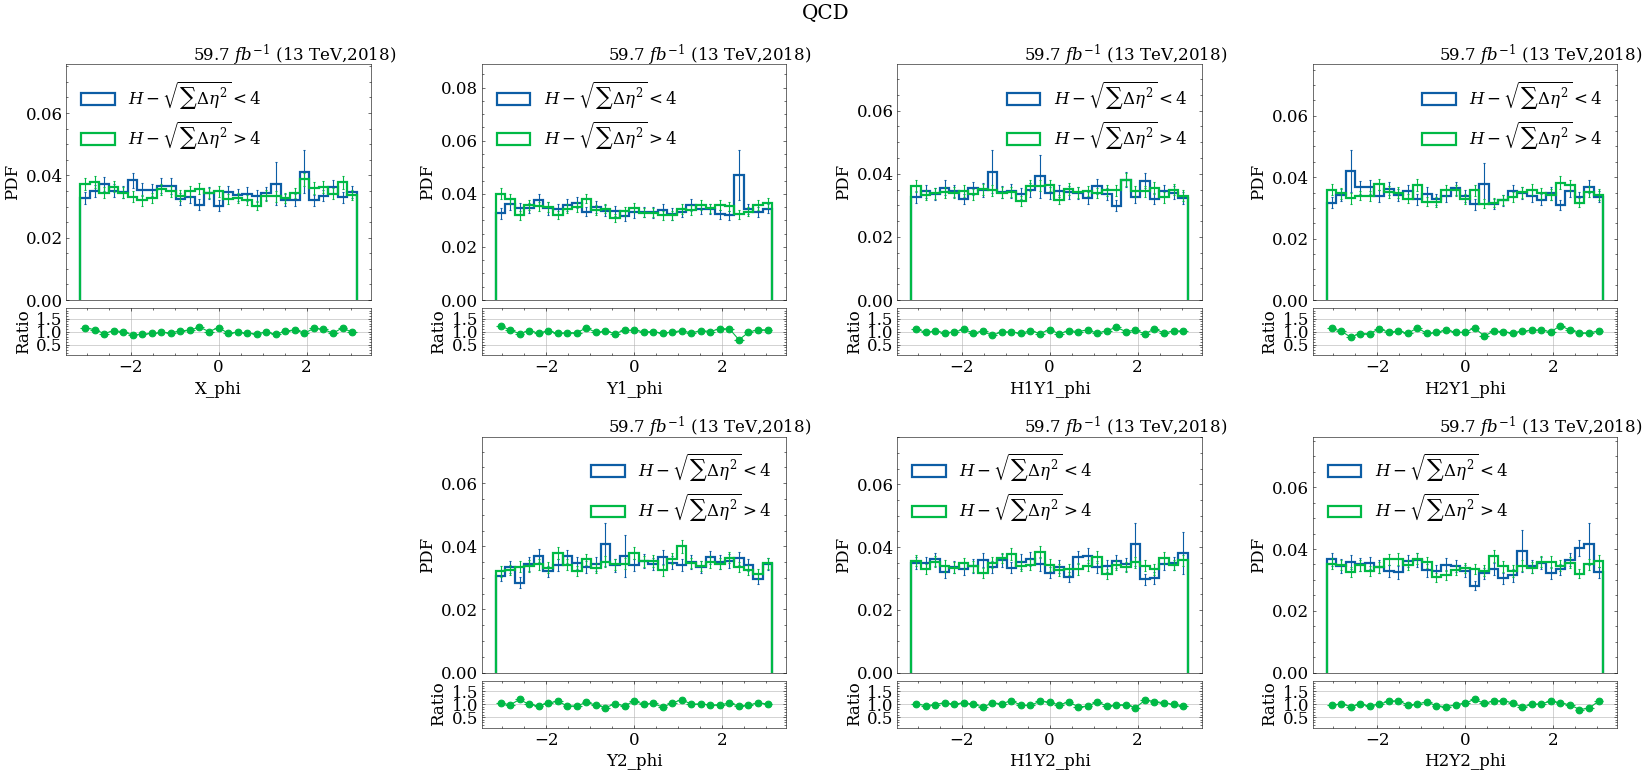

In [79]:
study.quick(
    bkgtrees[[0,0]],legend=True,title='QCD',
    masks = [l4_h_detasum,g4_h_detasum],
    h_color=None, label=['$H - \sqrt{\sum\Delta\eta^2} < 4$', '$H - \sqrt{\sum\Delta\eta^2} > 4$'],
    varlist=['h_detasum'],binlist=[np.linspace(0,12,30)]
)

for var in ('pt','m','eta','phi'):
    study.quick(
        bkgtrees[[0,0,0]],title='QCD',legend=True, h_label_stat=None,
        masks = [l4_h_detasum,g4_h_detasum],
        h_color=None, label=['$H - \sqrt{\sum\Delta\eta^2} < 4$', '$H - \sqrt{\sum\Delta\eta^2} > 4$'],
        varlist=[(f'{obj}_{var}' if obj else None) for obj in objlist], dim=(-1,4),
        # varlist=['X_m'],
        density=True,
        ratio=True,r_inv=True,
    )

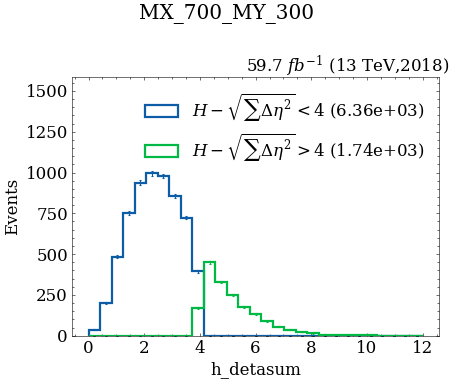

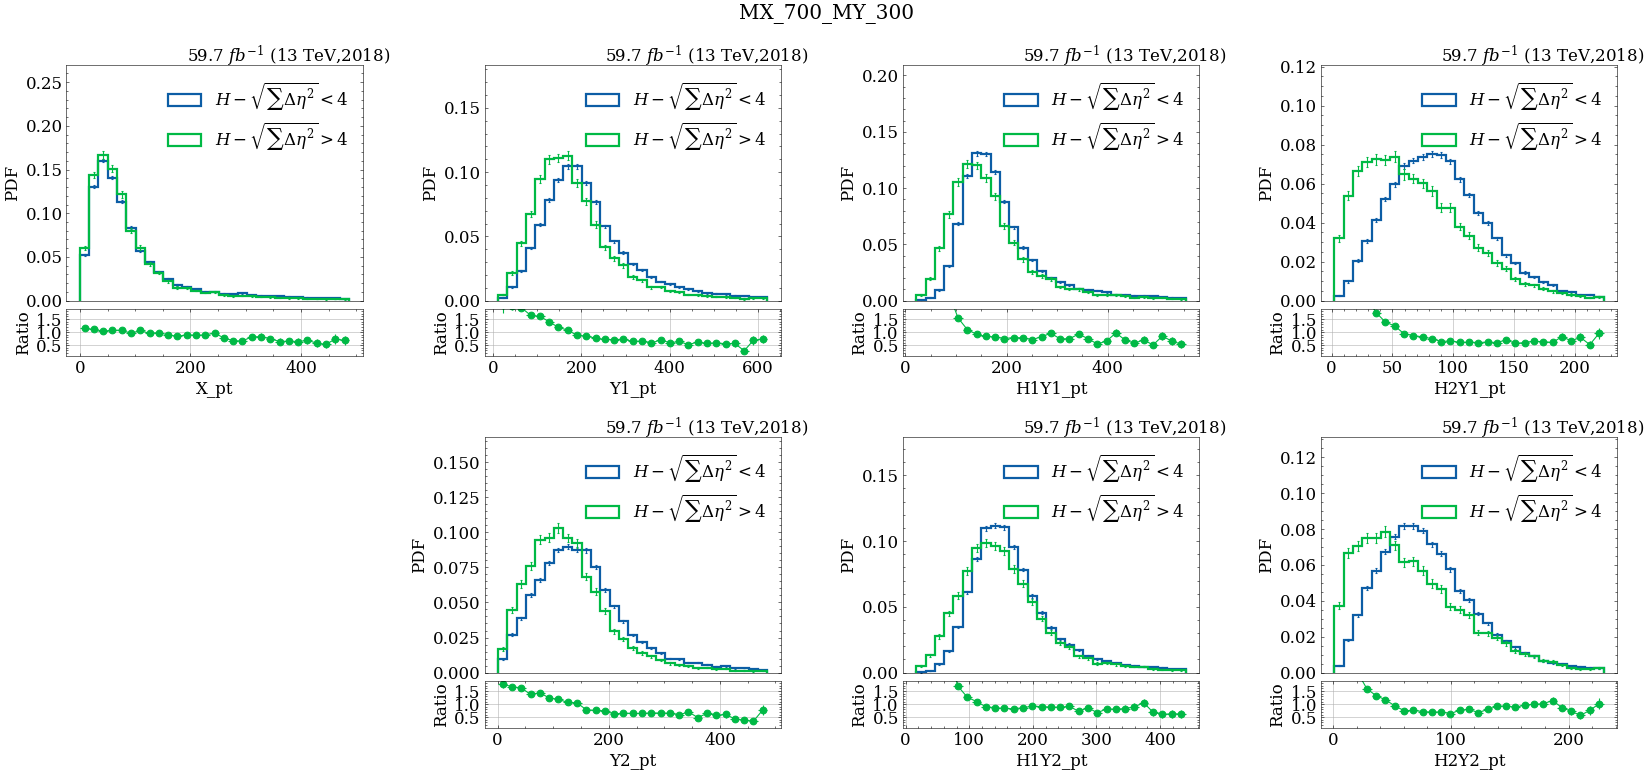

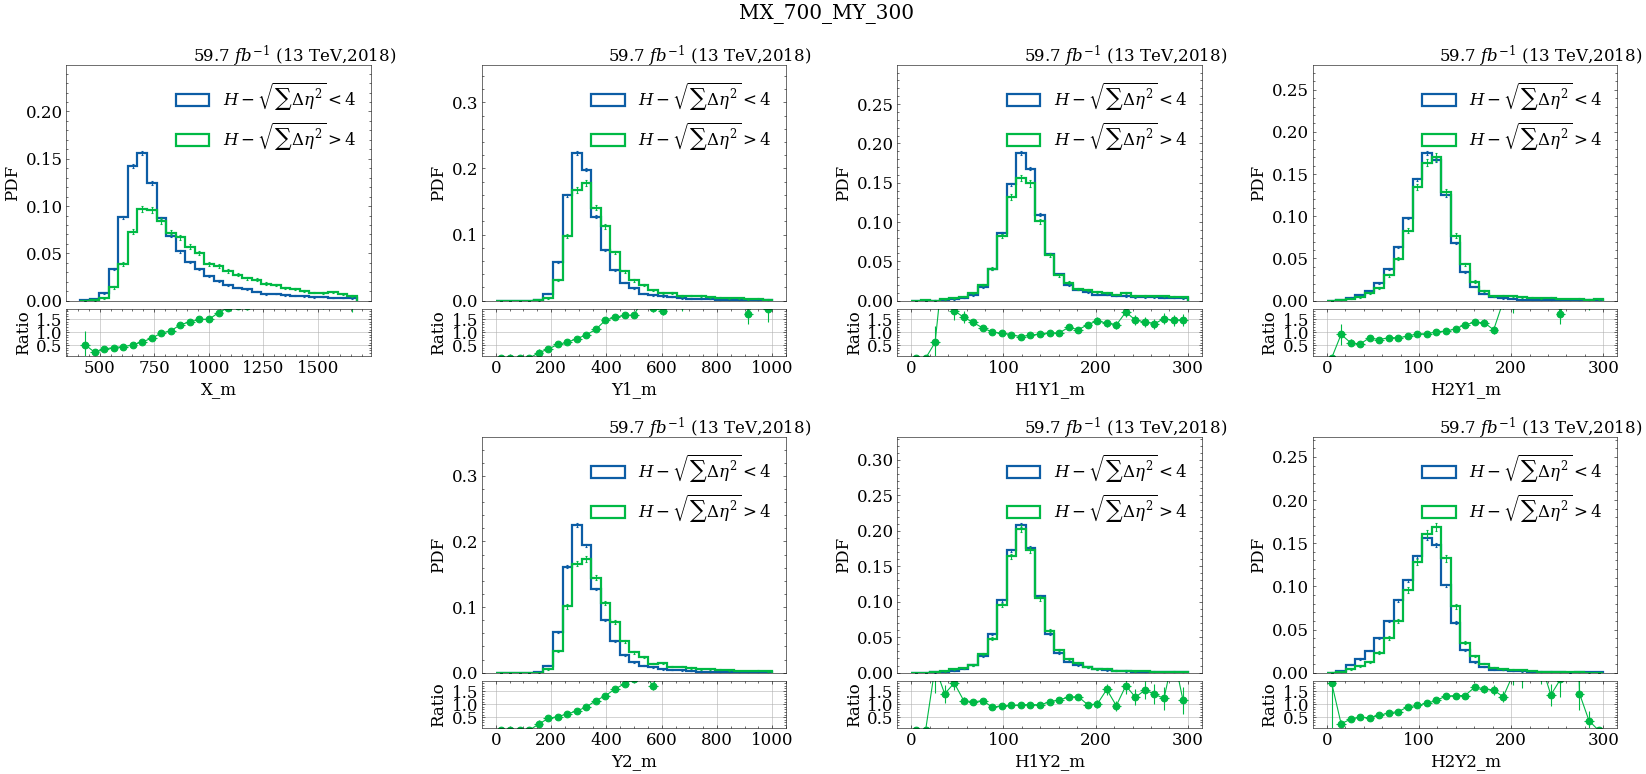

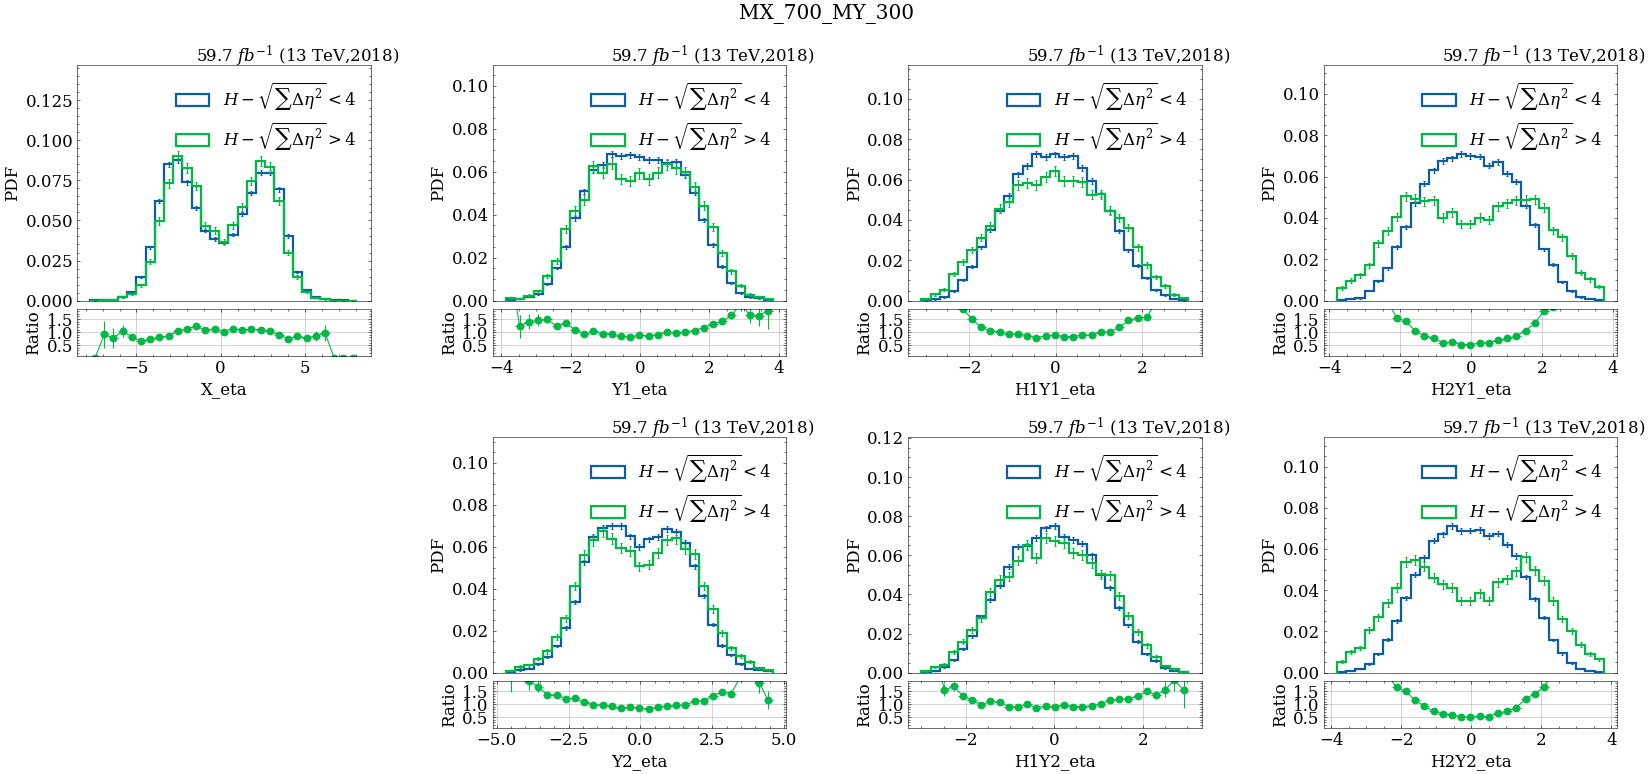

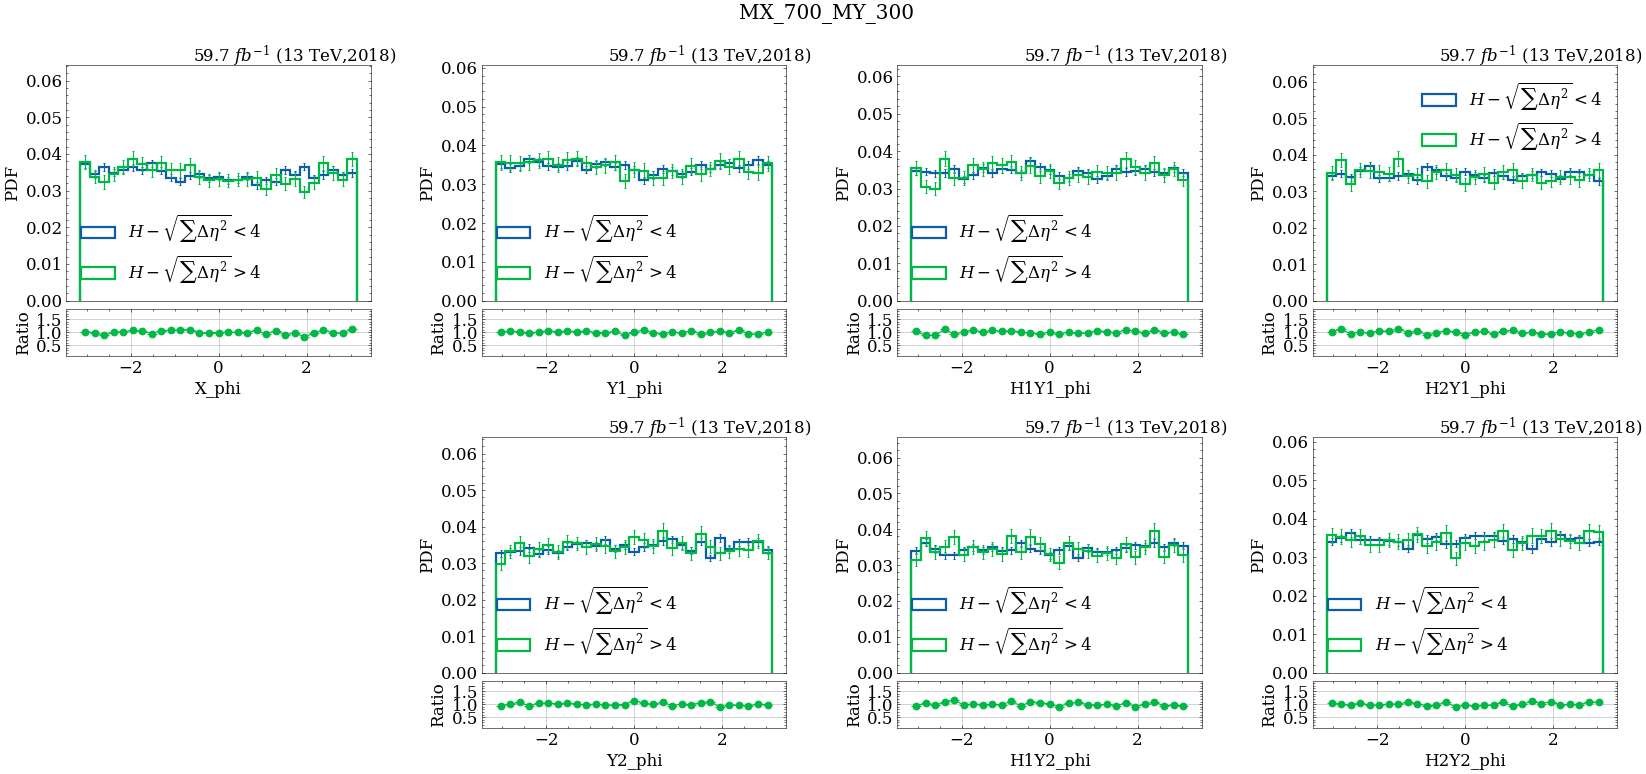

In [78]:
study.quick(
    signaltrees[[0,0]],legend=True,title=signaltrees[0].sample,
    masks = [l4_h_detasum,g4_h_detasum],
    h_color=None, label=['$H - \sqrt{\sum\Delta\eta^2} < 4$', '$H - \sqrt{\sum\Delta\eta^2} > 4$'],
    varlist=['h_detasum'],binlist=[np.linspace(0,12,30)]
)

for var in ('pt','m','eta','phi'):
    study.quick(
        signaltrees[[0,0,0]],title=signaltrees[0].sample,legend=True, h_label_stat=None,
        masks = [l4_h_detasum,g4_h_detasum],
        h_color=None, label=['$H - \sqrt{\sum\Delta\eta^2} < 4$', '$H - \sqrt{\sum\Delta\eta^2} > 4$'],
        varlist=[(f'{obj}_{var}' if obj else None) for obj in objlist], dim=(-1,4),
        # varlist=['X_m'],
        density=True,
        ratio=True,r_inv=True,
    )

In [185]:
from sklearn.decomposition import PCA

def raw_features(tree):
    features =  ak.concatenate([ np.abs(tree.hij_dm),tree.y_dm],axis=-1)
    return features.to_numpy()

X = ak.concatenate(signaltrees.apply(raw_features).list).to_numpy()
X_mean, X_std = np.mean(X,axis=0), np.std(X,axis=0)
X = (X-X_mean)/X_std

def build_features(tree):
    features = raw_features(tree)
    return (features-X_mean)/X_std

In [186]:
pca = PCA(n_components=4)
pca.fit(X)
pca.explained_variance_ratio_


array([0.25418031, 0.16687396, 0.14720795, 0.14136539])

In [187]:
signal_ys = signaltrees.apply(build_features).apply(pca.transform)

In [188]:
bkg_ys = bkgtrees.apply(build_features).apply(pca.transform)

In [200]:
class lumi_scale(ObjTransform):
    def __call__(self, t):
        scale = t.scale
        return lumiMap[self.lumi][0]*scale

(<Figure size 384x360 with 2 Axes>, <AxesSubplot:ylabel='Events'>)

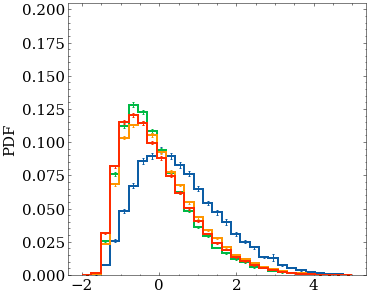

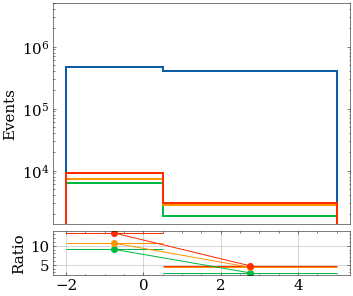

In [203]:
hist_multi((bkg_ys+signal_ys).apply(lambda a : a[:,0]).list, weights=(bkgtrees+signaltrees).apply(lumi_scale(lumi=2018)).list,bins=np.linspace(-2,5,30),density=True)
hist_multi((bkg_ys+signal_ys).apply(lambda a : a[:,0]).list, weights=(bkgtrees+signaltrees).apply(lumi_scale(lumi=2018)).list,bins=np.array((-2,0.5,5)),log=True, ratio=True, r_inv=True, r_den_transform=np.sqrt, r_ylim=None,)
# hist_multi((bkg_ys+signal_ys).apply(lambda a : a[:,1]).list, weights=(bkgtrees+signaltrees).scale.list,bins=np.linspace(-2,5,30), density=True)

(<Figure size 384x360 with 2 Axes>, <AxesSubplot:ylabel='Events'>)

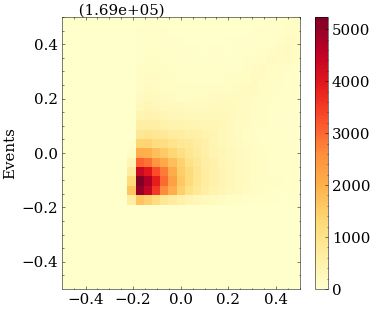

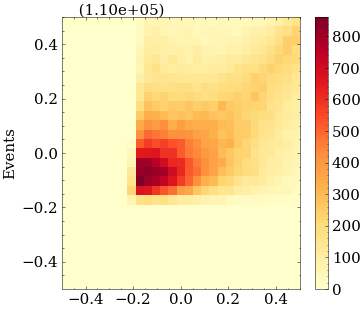

In [113]:
from utils.plotUtils.multi_plotter import hist2d_simple
hist2d_simple(y[:,0],y[:,1],x_bins=np.linspace(-0.5,0.5,30),y_bins=np.linspace(-0.5,0.5,30))
hist2d_simple(bkg_ys[0][:,0],bkg_ys[0][:,1],x_bins=np.linspace(-0.5,0.5,30),y_bins=np.linspace(-0.5,0.5,30))
